## Model Training on US-Accidents Processed Dataset
- Data processing can be accessed from this [Kaggle Notebook](https://www.kaggle.com/code/yuvrajdhepe/project-4-us-accidents/notebook)
- In this notebook Classification models are trained and compared
- The training is done on **partial data** cause few models take too much time to train and find best params using grid search
- After training, we retrain the best models on the whole data and compare between them
- In the end we conclude with our findings

- We will be using these models:
    - Logistic Regression
    - Decision Tree Classifier
    - Random Forest Classifier
    - Naive Bayes
    - Gaussian Naive Bayes
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
    - XGBoost Classifier
    - Multi Layer Perceptron Classifier
    - SVM Classifier
- We will also try to search for best hyper-params to produce the best results for models. 
- Finally we will compare all the models using different metrics of **Precision, Recall, Accuracy, ROC, PR curves**
- **Comments are put wherever necessary and if the code is repetitive it's not commented since the logic is same as earlier commented code**

## Importing the necessary Libraries

In [280]:
import pandas as pd
import pyarrow as pa
import polars as pl
import vaex as vx
#import pyarrow.parquet as pq
#import dask.dataframe as dd

import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from nltk.corpus import stopwords

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB, BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.impute import SimpleImputer
#from ydata_profiling import ProfileReport

## Loading, Splitting & Sampling the Dataset

In [281]:
df_model = pd.read_pickle("/kaggle/input/us-accidents-processed/final_df.pickle")

In [282]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252372 entries, A-516257 to A-4833008
Data columns (total 56 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Severity                            252372 non-null  uint8  
 1   Start_Lat                           252372 non-null  float32
 2   Start_Lng                           252372 non-null  float32
 3   Distance(mi)                        252372 non-null  float32
 4   Temperature(F)                      252372 non-null  float32
 5   Humidity(%)                         252372 non-null  float32
 6   Pressure(in)                        252372 non-null  float32
 7   Wind_Speed(mph)                     252372 non-null  float32
 8   Amenity                             252372 non-null  uint8  
 9   Crossing                            252372 non-null  uint8  
 10  Junction                            252372 non-null  uint8  
 11  No_Exit              

### Formulas

$$
Precision = \frac{TP}{TP+FP}
$$

$$
TPR/Recall = \frac{TP}{TP+FN}
$$

$$
Accuracy: \frac{TP+TN}{TP+TN+FP+FN}
$$

$$
FPR = \frac{FP}{TN+FP}
$$
"
$$
F1 = \frac{2*Precision*Recall}{Precision+Recall}= \frac{2*TP}{2*TP+FP+FN}
$$

#### Metrics 

In [283]:
### Storing every models following metrics in dictionary
accuracy = dict()
precision = dict()
recall = dict()
f1 = dict()
fpr = dict() 
tpr = dict()
best_params = dict() #Storing the best parameters for models that use gridsearchCV
models = dict() # Storing the trained model in dictionary

#### Splitting the data into test, train and validation sets

In [284]:
# Train/Validation - Test split
X,X_test = train_test_split(df_model,test_size = .2, random_state = 42)
print(X.shape, X_test.shape)

(201897, 56) (50475, 56)


In [285]:
y = X["Severity"] # Separating the target variable from the dataset

In [286]:
X_model = X.drop(["Severity"],axis = 1) # Createing a df of only features

In [287]:
# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_model,y,random_state = 42,test_size = 0.20)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(161517, 55) (40380, 55) (161517,) (40380,)


In [288]:
## We will run the grid search cv only on 24_000 samples, to use less compute but find the best params
## Doing this is necessary cause few model being complex like SVM take too much time to find best params 
X_sample = X.sample(24_000, random_state = 42)
y_sample_train = X_sample["Severity"]
X_sample_train = X_sample.drop(["Severity"],axis =1)
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_sample_train, y_sample_train, test_size = .2, random_state = 42)

In [289]:
X_train_sample.shape, X_val_sample.shape

((19200, 55), (4800, 55))

## Model Training

### Logistic Regression Model

#### Grid Search CV(5-folds) RUN to find best Params 

In [290]:
# Defining the model and it's parameters
lr = LogisticRegression(random_state = 42, n_jobs =-1,max_iter = 100)
params = {"solver": ["sag","saga"]}

# Performing Grid Search to find best params
grid = GridSearchCV(lr, params, n_jobs =1,verbose = 0,)
grid.fit(X_train_sample, y_train_sample)

print("Best parameter scores:")
print(grid.best_params_)

# Storing the best Params to be used in training on whole dataset if it's a best model compared to others
best_params["lr"] = grid.best_params_
print(f"Train score: {grid.score(X_train_sample, y_train_sample)}")

Best parameter scores:
{'solver': 'saga'}
Train score: 0.6977083333333334


In [291]:
# Observing the data frame on fitted models 
df = (pd.DataFrame(grid.cv_results_,index = ['sag','saga'])).drop(["param_solver"],axis = 1)
df = df.rename_axis('Solver', axis='index')
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
Solver,,,,,,,,,,,,,
sag,1.262635,0.397594,0.006319,0.003799,{'solver': 'sag'},0.692448,0.698438,0.678125,0.701823,0.698177,0.693802,0.008397,2
saga,2.885478,0.244466,0.004469,0.000096,{'solver': 'saga'},0.692708,0.698698,0.678385,0.701823,0.698177,0.693958,0.008321,1


#### Running the best params logistic regression model

In [292]:
print("Best Param scores for Logistic Regression:")
lr = LogisticRegression(**grid.best_params_, random_state = 42,)
lr.fit(X_train_sample, y_train_sample)

# Storing the model trained with best params later used for visualizations
models["Logistic Regression"] = lr


print("Train score:", lr.score(X_train_sample, y_train_sample))
print("Validation score:", lr.score(X_val_sample, y_val_sample))

Best Param scores for Logistic Regression:
Train score: 0.6977083333333334
Validation score: 0.6827083333333334


#### Logistic Regression Conf. Matrix on Validation set

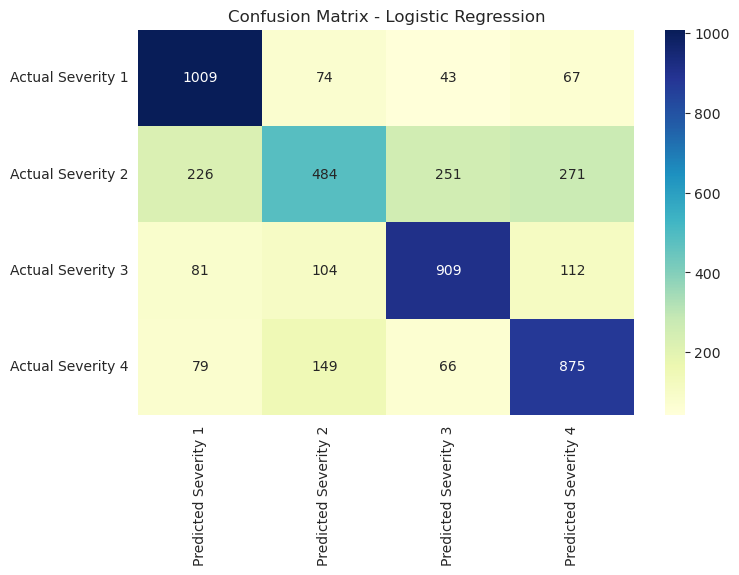

In [293]:
y_pred = lr.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#### Metrics Scores and Metric Visualizations for Logistic Regression with best params

In [294]:
# Observing the classification report for Logistic Regression
y_pred = lr.predict(X_val_sample)

# Store the respective scores
accuracy["Logistic Regression"] = accuracy_score(y_val_sample,y_pred)
f1["Logistic Regression"] = f1_score(y_val_sample,y_pred,average = 'macro')

# Classification report on train and Val data
print(classification_report(y_train_sample,lr.predict(X_train_sample)))
print(classification_report(y_val_sample,y_pred))

              precision    recall  f1-score   support

           1       0.75      0.86      0.80      4822
           2       0.61      0.39      0.47      4734
           3       0.72      0.79      0.75      4865
           4       0.67      0.75      0.71      4779

    accuracy                           0.70     19200
   macro avg       0.69      0.70      0.68     19200
weighted avg       0.69      0.70      0.68     19200

              precision    recall  f1-score   support

           1       0.72      0.85      0.78      1193
           2       0.60      0.39      0.47      1232
           3       0.72      0.75      0.73      1206
           4       0.66      0.75      0.70      1169

    accuracy                           0.68      4800
   macro avg       0.67      0.69      0.67      4800
weighted avg       0.67      0.68      0.67      4800



#### Logistic Regression Precision vs Recall Curve on Validation set

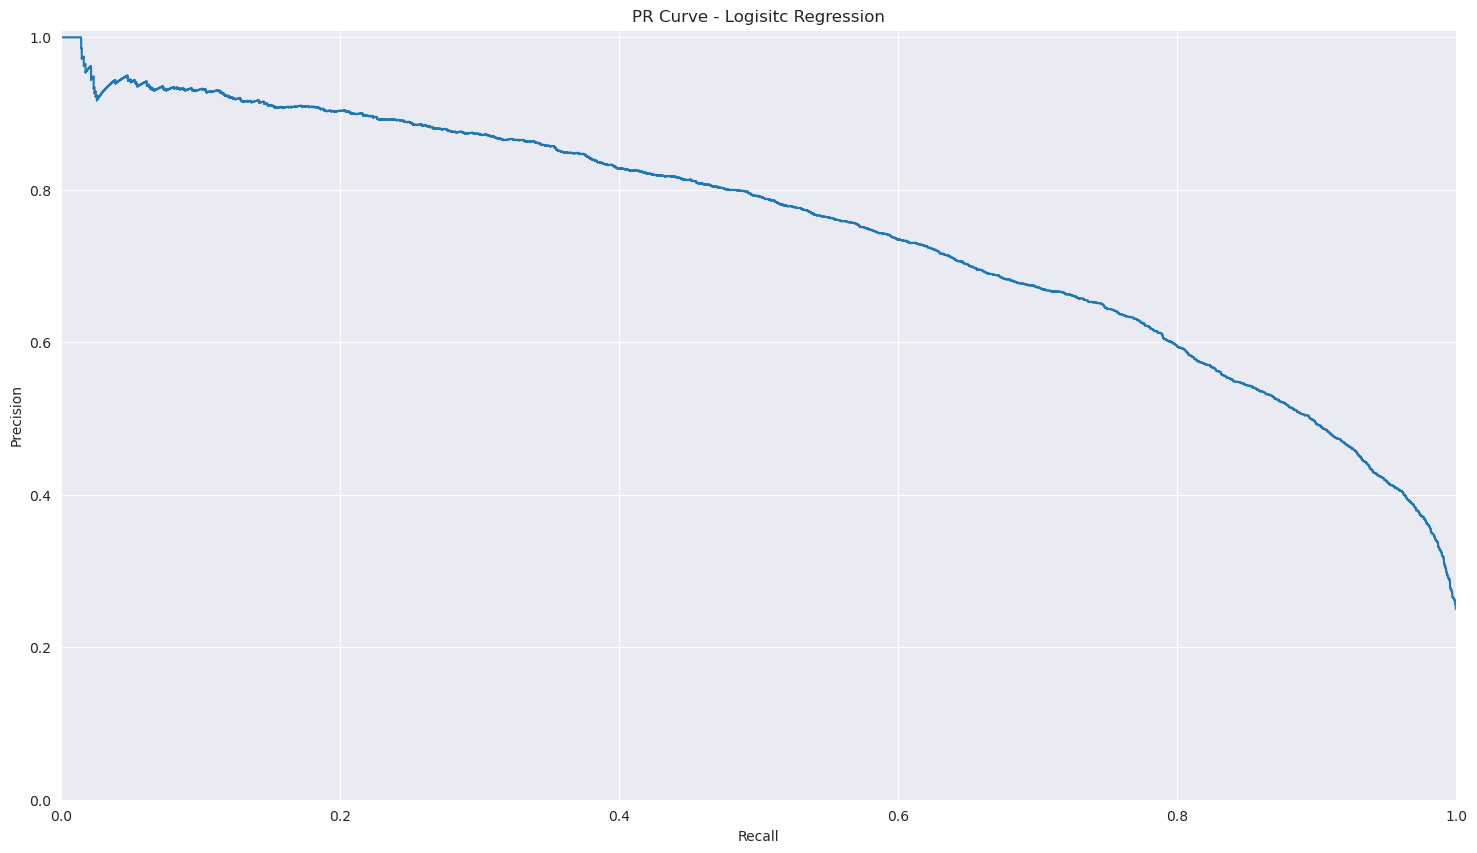

In [295]:
# Creates a 2d array from 1d array of y_val_sample, where each instance represents presence of one severity via 1 and rest are 0's.
# This is necessary since predictions are in 2d format 
# Creating a pr curve tests these arrays i.e. true_y_values and predictions on different 
# thresholds, so binarizing is helpful to make y_val and preds of same size to be compared

Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = lr.predict_proba(X_val_sample)

#Storing the metrics for later viz's
precision["Logistic Regression"], recall["Logistic Regression"], thresholds = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Logistic Regression"], tpr["Logistic Regression"], _ = roc_curve(Y.ravel(), y_score.ravel())

# Plotting the PR Curve
plt.figure(figsize=(18, 10))
plt.step(recall["Logistic Regression"], precision["Logistic Regression"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Logisitc Regression")
plt.show()
# The curve is better the one which is near to right hand corner [1,1]

#### Logistic Regression ROC Curve on Validation set

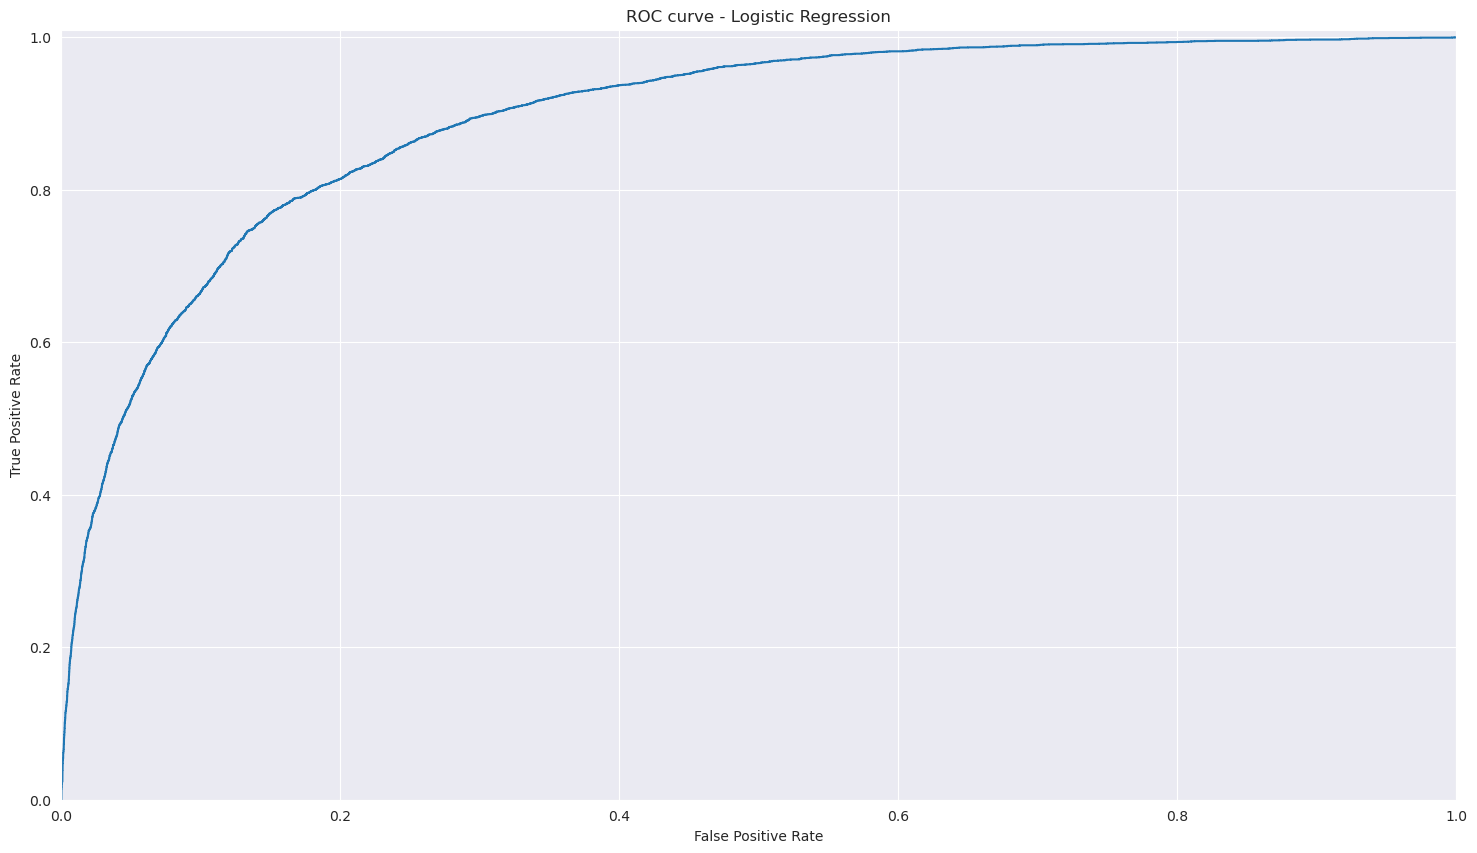

In [296]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Logistic Regression"], tpr["Logistic Regression"], where="post")

plt.title("ROC curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()
# The curve is better the one which is near to left hand corner [0,1]

In [297]:
# thresholds.shape, y_score.ravel().shape # We have this difference because thresholds are chosen as many different probability instances we havex
# print(Y.shape,Y.ravel().shape,y_score.shape,y_score.ravel().shape)
# y = np.array([[1,2,3,4],[4,3,2,1],[1,2,3,4]])
# unique,counts = np.unique(y,return_counts=True)
# print(unique)
# unique,counts = np.unique(y_score,return_counts = True)
# print(len(unique)) # So we only have these many instances, which have unique prediction probabilities

### Decision Tree Model

#### Decision Tree Grid Search CV(5-folds) Run to find best params

In [298]:
dtc = DecisionTreeClassifier(random_state=42)
parameters = [{"criterion": ["gini", "entropy"], "max_depth": [5, 10, 15, 30]}]

grid = GridSearchCV(dtc, parameters, verbose = 0, n_jobs=-1)
grid.fit(X_train_sample, y_train_sample)

print("Best param scores for Decision Tree Classifier:")
print(grid.best_params_)
best_params["dtc"] = grid.best_params_

print("Train score:", grid.score(X_train_sample, y_train_sample))
print("Validation score:", grid.score(X_val_sample, y_val_sample))

Best param scores for Decision Tree Classifier:
{'criterion': 'entropy', 'max_depth': 10}
Train score: 0.823125
Validation score: 0.7672916666666667


In [299]:
pd.DataFrame(grid.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.255957,0.014855,0.005243,0.000257,entropy,10,"{'criterion': 'entropy', 'max_depth': 10}",0.752865,0.757812,0.752604,0.768750,0.759375,0.758281,0.005875,1
1,0.194180,0.013044,0.005411,0.000337,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.749479,0.763802,0.748958,0.763281,0.763281,0.757760,0.006979,2
4,0.140707,0.008412,0.004997,0.000269,entropy,5,"{'criterion': 'entropy', 'max_depth': 5}",0.739062,0.742969,0.744792,0.741406,0.742969,0.742240,0.001916,3
0,0.104274,0.002262,0.005177,0.000280,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.738802,0.744792,0.728125,0.746094,0.747917,0.741146,0.007192,4
2,0.266166,0.012563,0.005544,0.000080,gini,15,"{'criterion': 'gini', 'max_depth': 15}",0.736979,0.741927,0.727604,0.734115,0.736979,0.735521,0.004689,5
6,0.328951,0.009996,0.005584,0.000248,entropy,15,"{'criterion': 'entropy', 'max_depth': 15}",0.727604,0.743490,0.724740,0.735417,0.733854,0.733021,0.006541,6
7,0.348827,0.017845,0.005383,0.000513,entropy,30,"{'criterion': 'entropy', 'max_depth': 30}",0.710938,0.717448,0.710938,0.713281,0.710938,0.712708,0.002538,7
3,0.334237,0.034283,0.007774,0.003789,gini,30,"{'criterion': 'gini', 'max_depth': 30}",0.712760,0.711979,0.706771,0.709375,0.711719,0.710521,0.002189,8


#### Running the best params Decision Tree  model

In [300]:
print("Best Param scores for Decision Tree Classifier:")
dtc = DecisionTreeClassifier(**grid.best_params_, random_state = 42)

dtc.fit(X_train_sample, y_train_sample)

# Storing the model trained with best params later used for visualizations
models["Decision Tree"] = dtc

print("Train score:", dtc.score(X_train_sample, y_train_sample))
print("Validation score:", dtc.score(X_val_sample, y_val_sample))

Best Param scores for Decision Tree Classifier:
Train score: 0.823125
Validation score: 0.7672916666666667


#### Decision Tree Conf. Matrix on Validation set

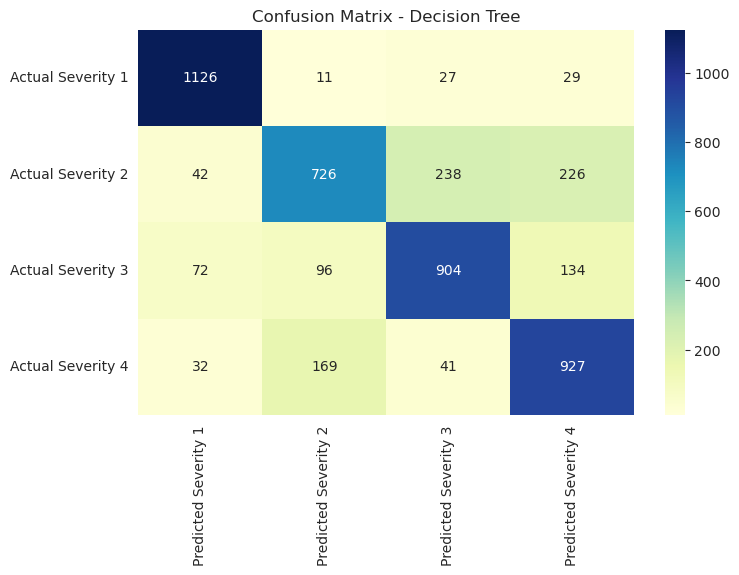

In [301]:
y_pred = dtc.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

#### Metrics Scores and Metric Visualizations for Decision Tree with best params

In [302]:
y_pred = dtc.predict(X_val_sample)

accuracy["Decision Tree"] = accuracy_score(y_val_sample, y_pred)
f1["Decision Tree"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, dtc.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       0.91      0.96      0.94      4822
           2       0.80      0.65      0.72      4734
           3       0.80      0.83      0.81      4865
           4       0.77      0.85      0.81      4779

    accuracy                           0.82     19200
   macro avg       0.82      0.82      0.82     19200
weighted avg       0.82      0.82      0.82     19200

              precision    recall  f1-score   support

           1       0.89      0.94      0.91      1193
           2       0.72      0.59      0.65      1232
           3       0.75      0.75      0.75      1206
           4       0.70      0.79      0.75      1169

    accuracy                           0.77      4800
   macro avg       0.77      0.77      0.76      4800
weighted avg       0.77      0.77      0.76      4800



#### Decision Tree Precision vs Recall Curve on Validation set

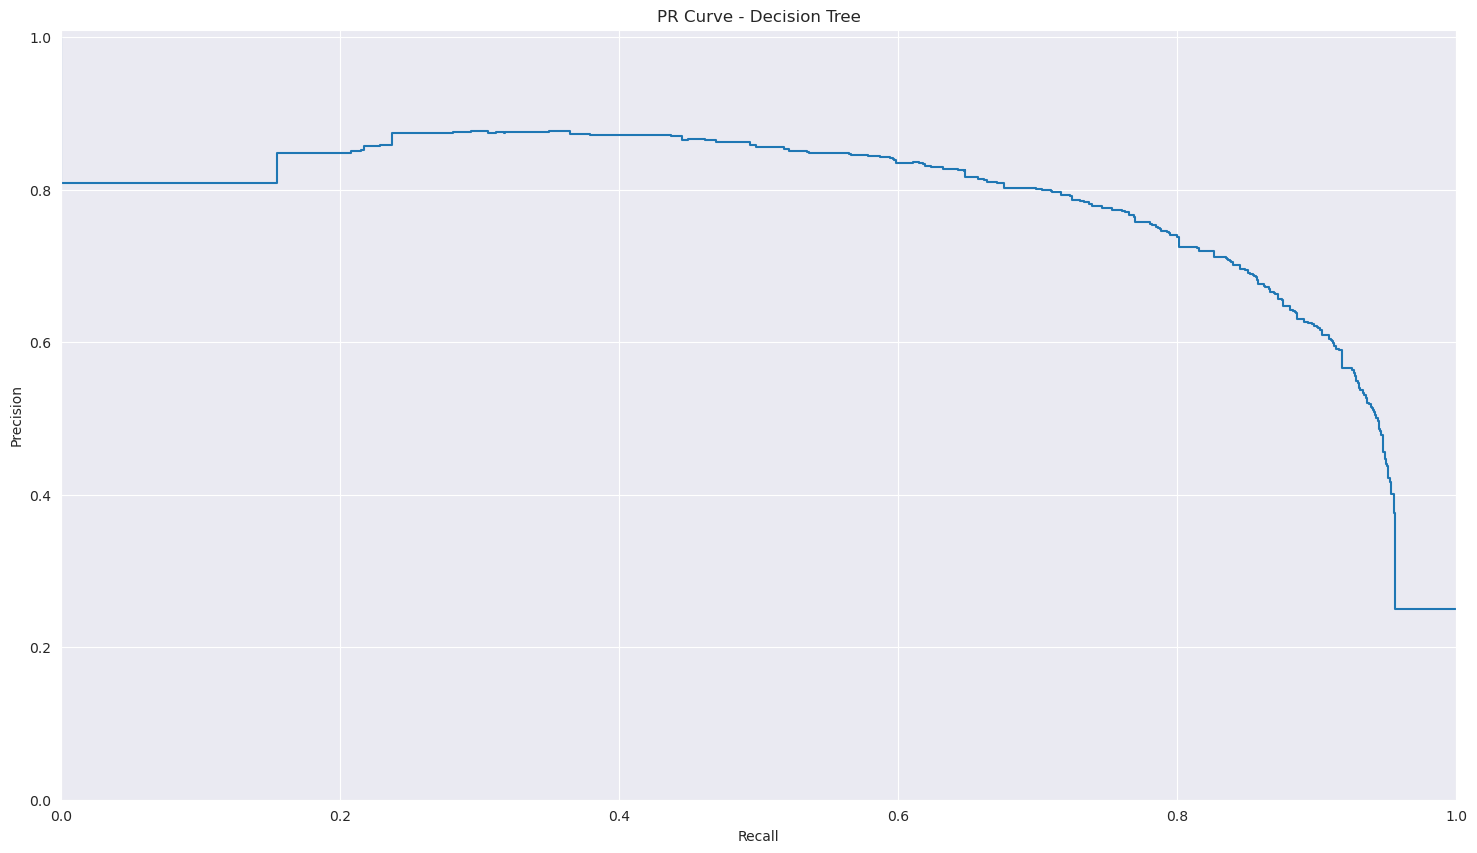

In [303]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = dtc.predict_proba(X_val_sample)

precision["Decision Tree"], recall["Decision Tree"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Decision Tree"], tpr["Decision Tree"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Decision Tree"], precision["Decision Tree"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Decision Tree")
plt.show()

#### Decision Tree ROC Curve on Validation set

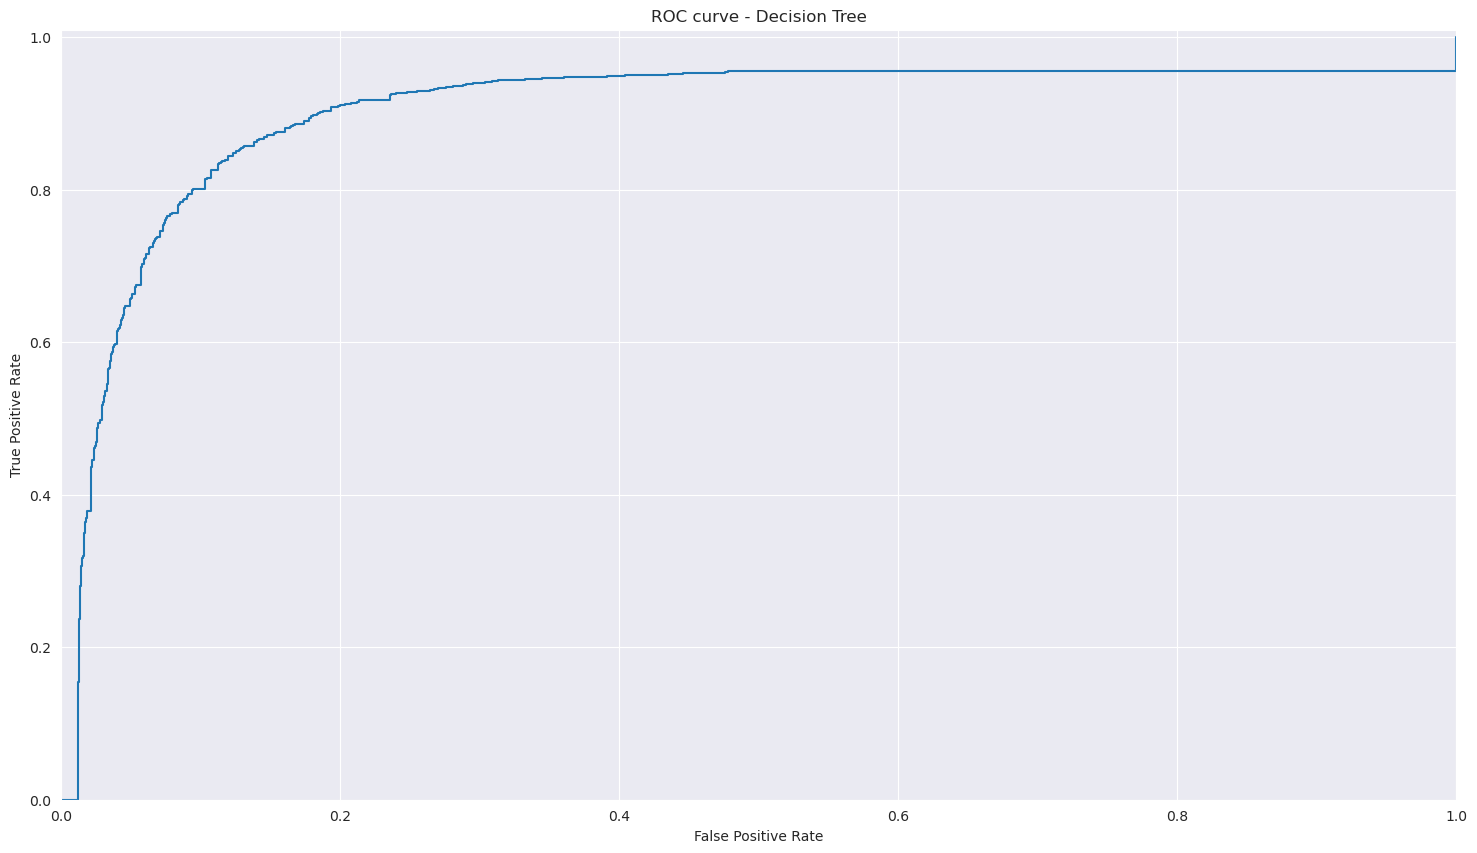

In [304]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Decision Tree"], tpr["Decision Tree"], where="post")

plt.title("ROC curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

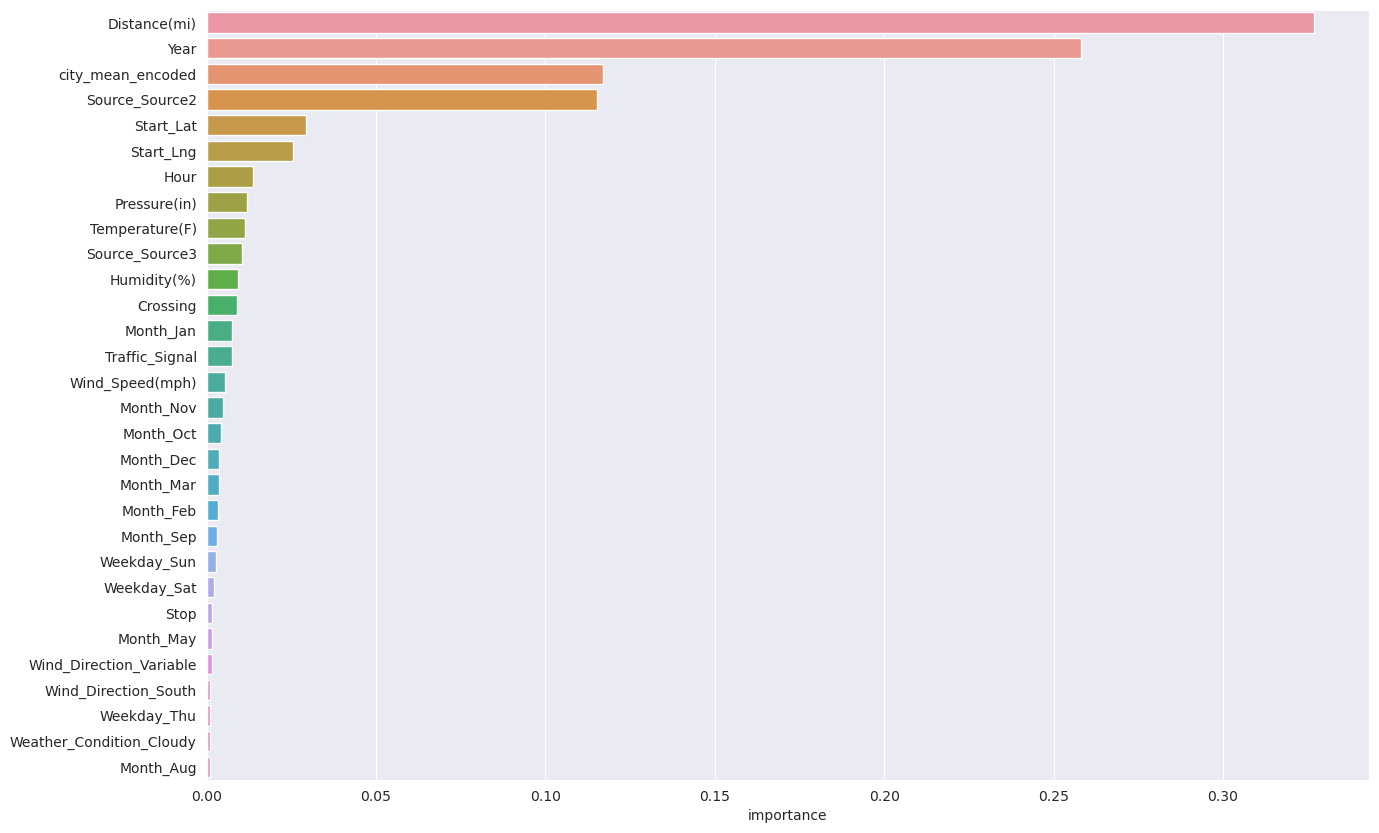

In [305]:
importances = pd.DataFrame(np.zeros((X_train_sample.shape[1], 1)), columns=["importance"], index=X_train_sample.columns)

importances.iloc[:,0] = dtc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

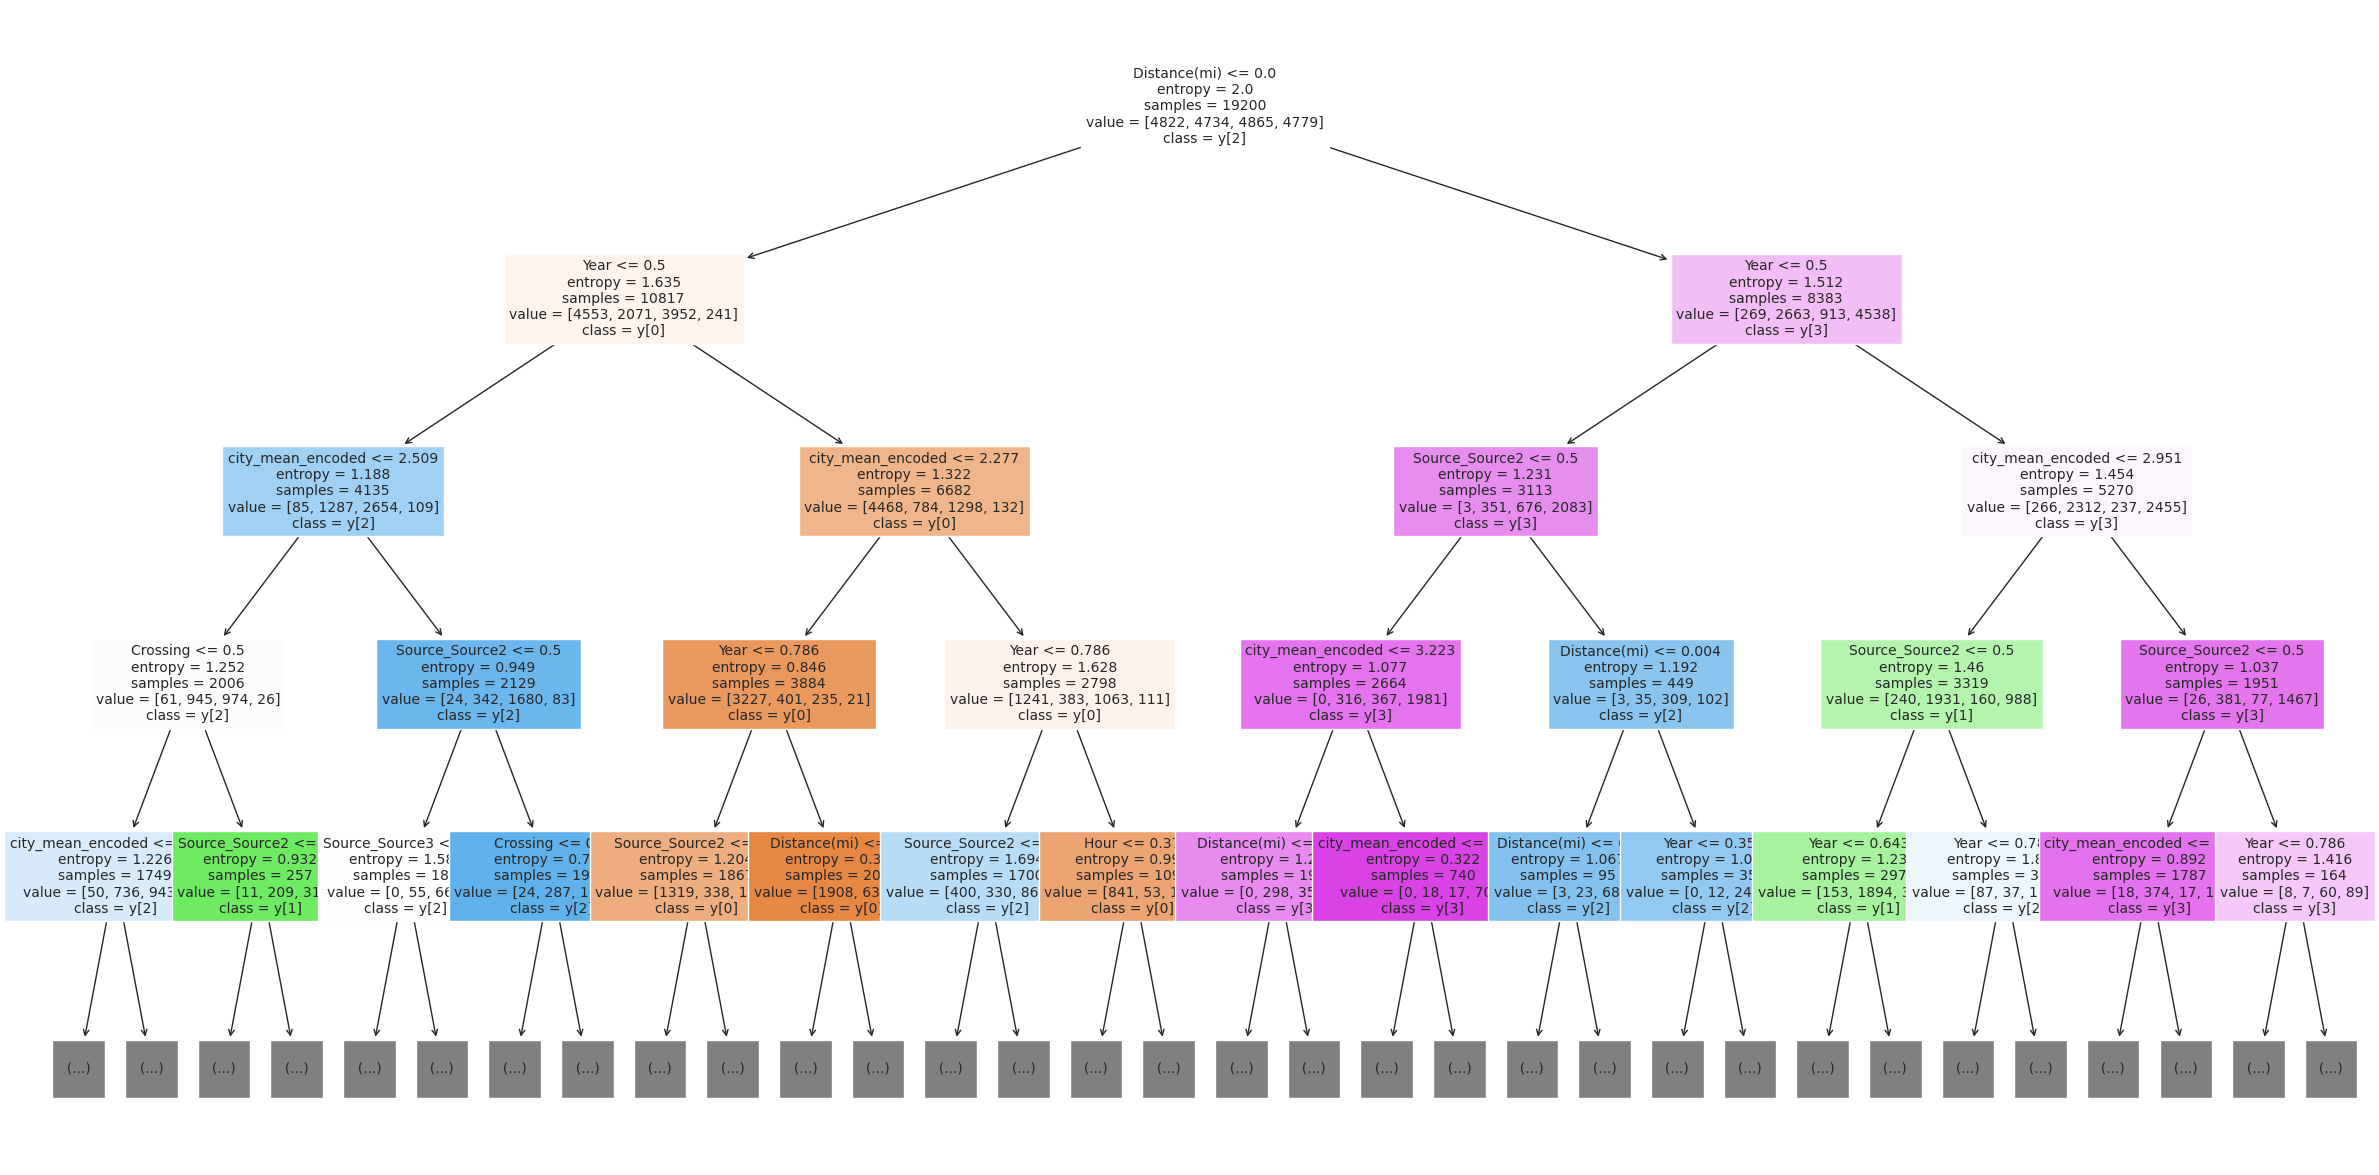

In [306]:
fig, ax = plt.subplots(figsize=(30, 15))
plot_tree(dtc, max_depth=4, fontsize=10, feature_names=X_train_sample.columns.to_list(), class_names = True, filled=True)
plt.show()

### Random Forest Classifier

#### Random Forest Classifier Grid Search CV (5 - folds) Run to find best params

In [307]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
parameters = [{"n_estimators": [50, 100, 200, 500], "max_depth": [5, 10, 15, 30]}]

grid = GridSearchCV(rfc, parameters, verbose = 0, n_jobs=-1)
grid.fit(X_train_sample, y_train_sample)

print("Best parameters scores:")
print(grid.best_params_)
best_params["rfc"] = grid.best_params_


print("Train score:", grid.score(X_train_sample, y_train_sample))
print("Validation score:", grid.score(X_val_sample, y_val_sample))

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters scores:
{'max_depth': 30, 'n_estimators': 500}
Train score: 0.9999479166666667
Validation score: 0.788125


In [308]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,18.515080,2.652032,0.737646,0.164817,30,500,"{'max_depth': 30, 'n_estimators': 500}",0.790365,0.788021,0.785417,0.792448,0.790365,0.789323,0.002404,1
13,3.962996,0.360099,0.180050,0.025820,30,100,"{'max_depth': 30, 'n_estimators': 100}",0.786979,0.786458,0.782292,0.790104,0.789062,0.786979,0.002696,2
14,7.875134,0.286106,0.332275,0.026725,30,200,"{'max_depth': 30, 'n_estimators': 200}",0.785937,0.786979,0.783854,0.788021,0.788542,0.786667,0.001667,3
11,16.402865,0.826905,0.633739,0.024163,15,500,"{'max_depth': 15, 'n_estimators': 500}",0.783594,0.784635,0.779948,0.784896,0.783594,0.783333,0.001774,4
12,1.989083,0.078801,0.100145,0.012897,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.779427,0.782552,0.777083,0.788802,0.785677,0.782708,0.004204,5
10,7.016634,0.366032,0.271259,0.017576,15,200,"{'max_depth': 15, 'n_estimators': 200}",0.782292,0.783333,0.777865,0.784115,0.783073,0.782135,0.002213,6
9,3.129164,0.103627,0.140270,0.007632,15,100,"{'max_depth': 15, 'n_estimators': 100}",0.783333,0.780990,0.777344,0.784115,0.780729,0.781302,0.002372,7
8,1.563844,0.036690,0.075092,0.009221,15,50,"{'max_depth': 15, 'n_estimators': 50}",0.780729,0.783594,0.775521,0.782813,0.778385,0.780208,0.002960,8
5,2.597278,0.374912,0.108515,0.014335,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.763802,0.766667,0.759115,0.770573,0.762500,0.764531,0.003875,9
4,1.120571,0.027130,0.056506,0.004969,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.762500,0.765885,0.755990,0.777604,0.760417,0.764479,0.007304,10


#### Running the best params Random Forest Classifier Model

In [309]:
print("Best Param scores for Random Forest Classifier:")
rfc = RandomForestClassifier(**grid.best_params_, random_state = 42)

rfc.fit(X_train_sample, y_train_sample)
# Storing the model trained with best params later used for visualizations
models["Random Forest"] = rfc

print("Train Score: ", rfc.score(X_train_sample, y_train_sample))
print("Validation Score: ", rfc.score(X_val_sample, y_val_sample))

Best Param scores for Random Forest Classifier:
Train Score:  0.9999479166666667
Validation Score:  0.788125


#### Random Forest Classifier Conf. Matrix on Validation Set

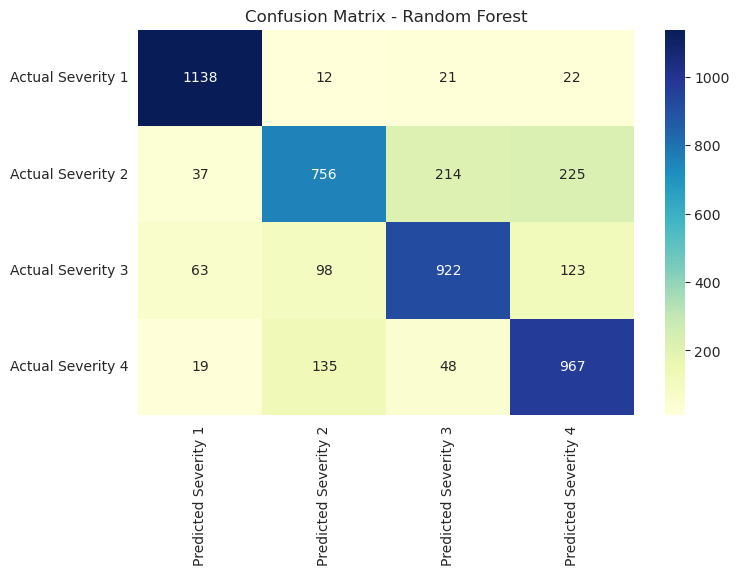

In [310]:
y_pred = rfc.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Random Forest")
plt.show()

#### Metrics Scores and Metric Visualizations for Random Forest Classifier with best params

In [311]:
y_pred = rfc.predict(X_val_sample)

accuracy["Random Forest"] = accuracy_score(y_val_sample, y_pred)
f1["Random Forest"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, rfc.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4822
           2       1.00      1.00      1.00      4734
           3       1.00      1.00      1.00      4865
           4       1.00      1.00      1.00      4779

    accuracy                           1.00     19200
   macro avg       1.00      1.00      1.00     19200
weighted avg       1.00      1.00      1.00     19200

              precision    recall  f1-score   support

           1       0.91      0.95      0.93      1193
           2       0.76      0.61      0.68      1232
           3       0.77      0.76      0.76      1206
           4       0.72      0.83      0.77      1169

    accuracy                           0.79      4800
   macro avg       0.79      0.79      0.79      4800
weighted avg       0.79      0.79      0.78      4800



#### Random Forest Classifier Precision vs Recall Curve on Validation Set

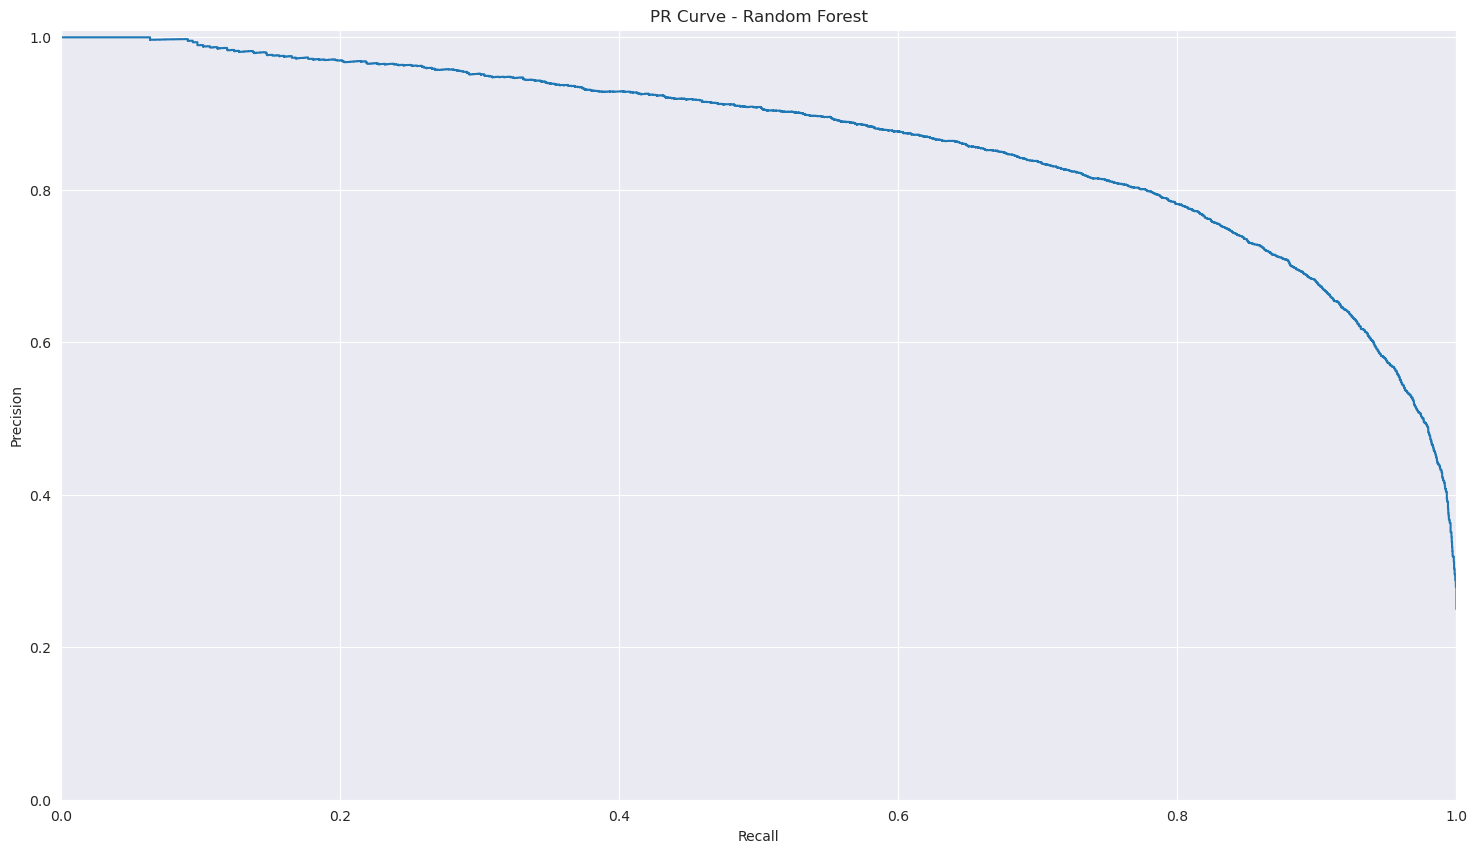

In [312]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = rfc.predict_proba(X_val_sample)

precision["Random Forest"], recall["Random Forest"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Random Forest"], tpr["Random Forest"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Random Forest"], precision["Random Forest"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Random Forest")
plt.show()

#### Random Forest Classifier ROC Curve on Validation Set

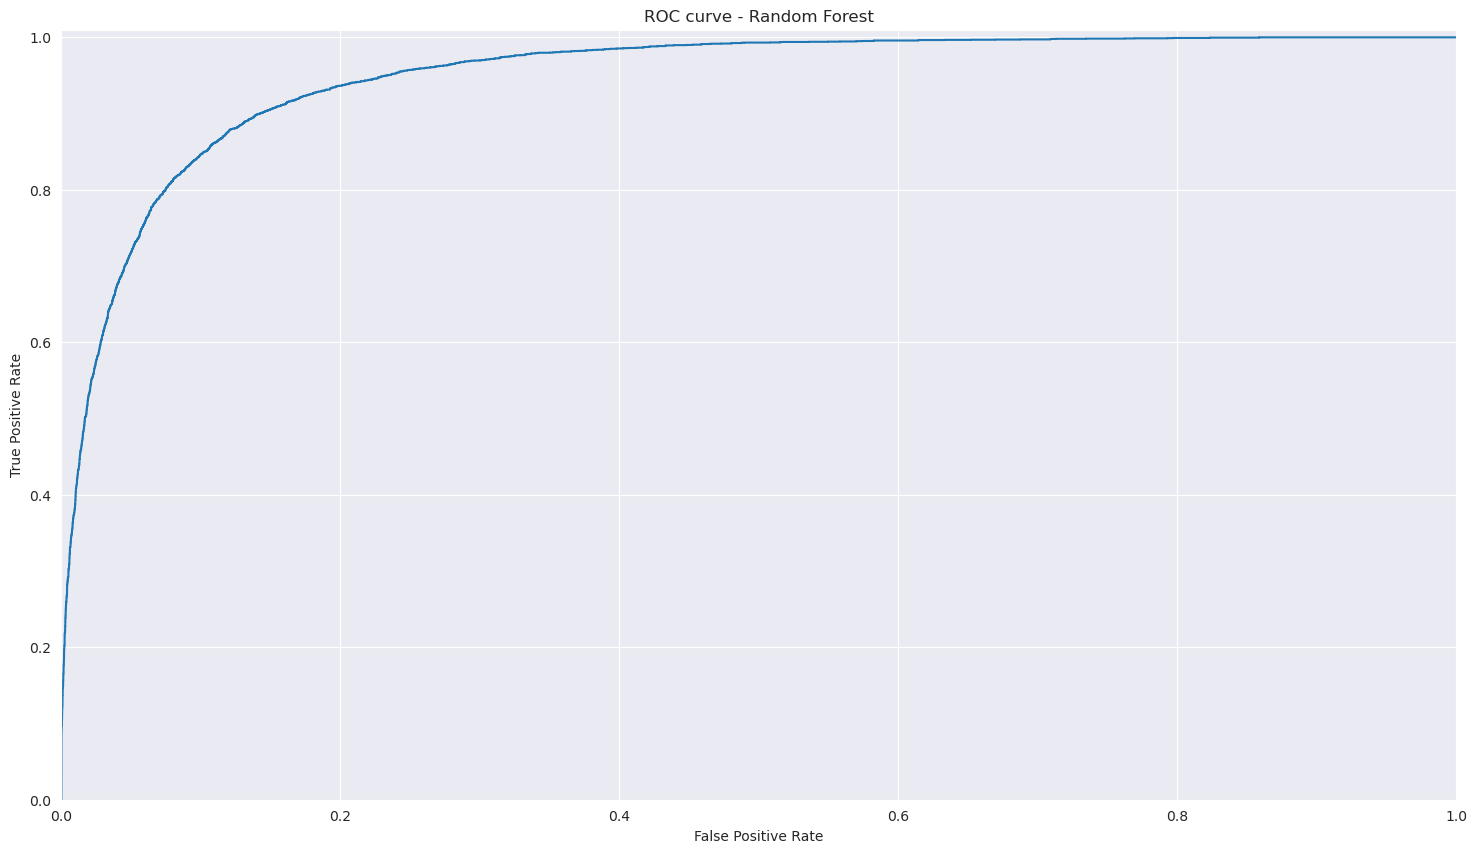

In [313]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Random Forest"], tpr["Random Forest"], where="post")

plt.title("ROC curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

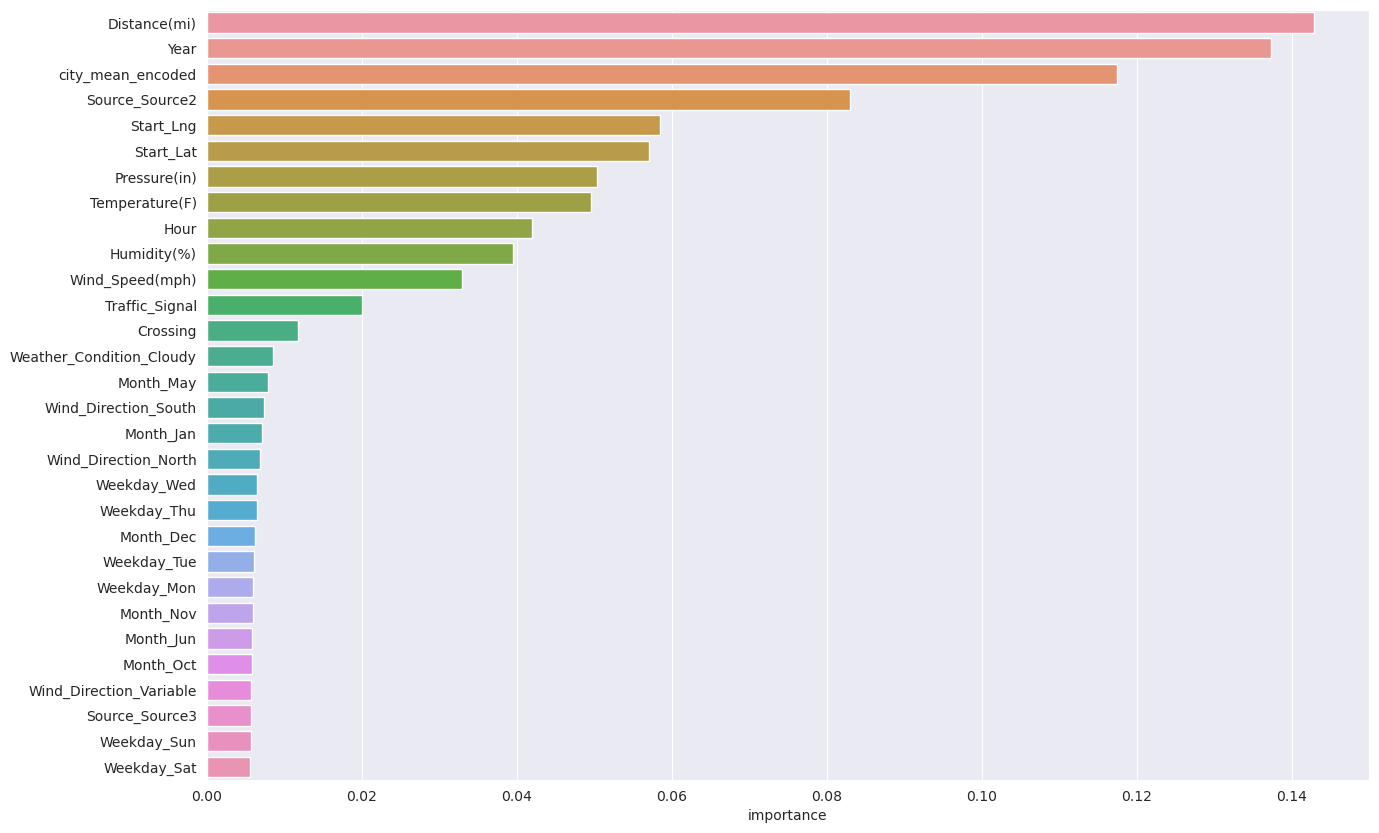

In [314]:
importances = pd.DataFrame(np.zeros((X_train_sample.shape[1], 1)), columns=["importance"], index=X_train_sample.columns)

importances.iloc[:,0] = rfc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

### Naive Bayes

#### Running algo without Grid-Search CV
- There are not major hyper params to be tweaked for this algo.

In [315]:
gnb = GaussianNB()

gnb.fit(X_train_sample, y_train_sample)

# Storing the model trained with best params later used for visualizations
models["Gaussian Naive Bayes"] = gnb

print("Train score:", gnb.score(X_train_sample, y_train_sample))
print("Validation score:", gnb.score(X_val_sample, y_val_sample))

Train score: 0.4340104166666667
Validation score: 0.42645833333333333


#### Gaussian Naive Bayes Conf. Matrix on Validation set

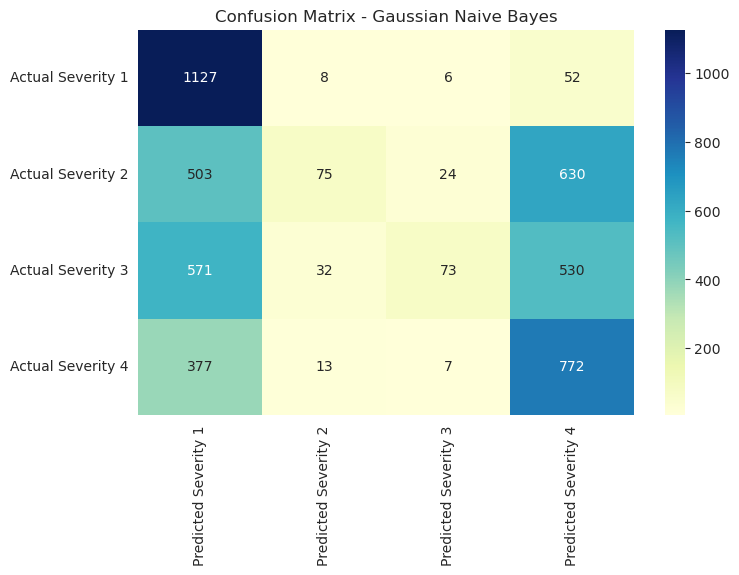

In [316]:
y_pred = gnb.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

#### Metrics Scores and Metric Visualizations for Gaussian Naive Bayes with best params

In [317]:
y_pred = gnb.predict(X_val_sample)

accuracy["Gaussian Naive Bayes"] = accuracy_score(y_val_sample, y_pred)
f1["Gaussian Naive Bayes"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, gnb.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       0.45      0.94      0.61      4822
           2       0.61      0.06      0.11      4734
           3       0.63      0.06      0.10      4865
           4       0.40      0.67      0.50      4779

    accuracy                           0.43     19200
   macro avg       0.52      0.43      0.33     19200
weighted avg       0.52      0.43      0.33     19200

              precision    recall  f1-score   support

           1       0.44      0.94      0.60      1193
           2       0.59      0.06      0.11      1232
           3       0.66      0.06      0.11      1206
           4       0.39      0.66      0.49      1169

    accuracy                           0.43      4800
   macro avg       0.52      0.43      0.33      4800
weighted avg       0.52      0.43      0.32      4800



#### Gaussian Naive Bayes Precision vs Recall Curve on Validation set

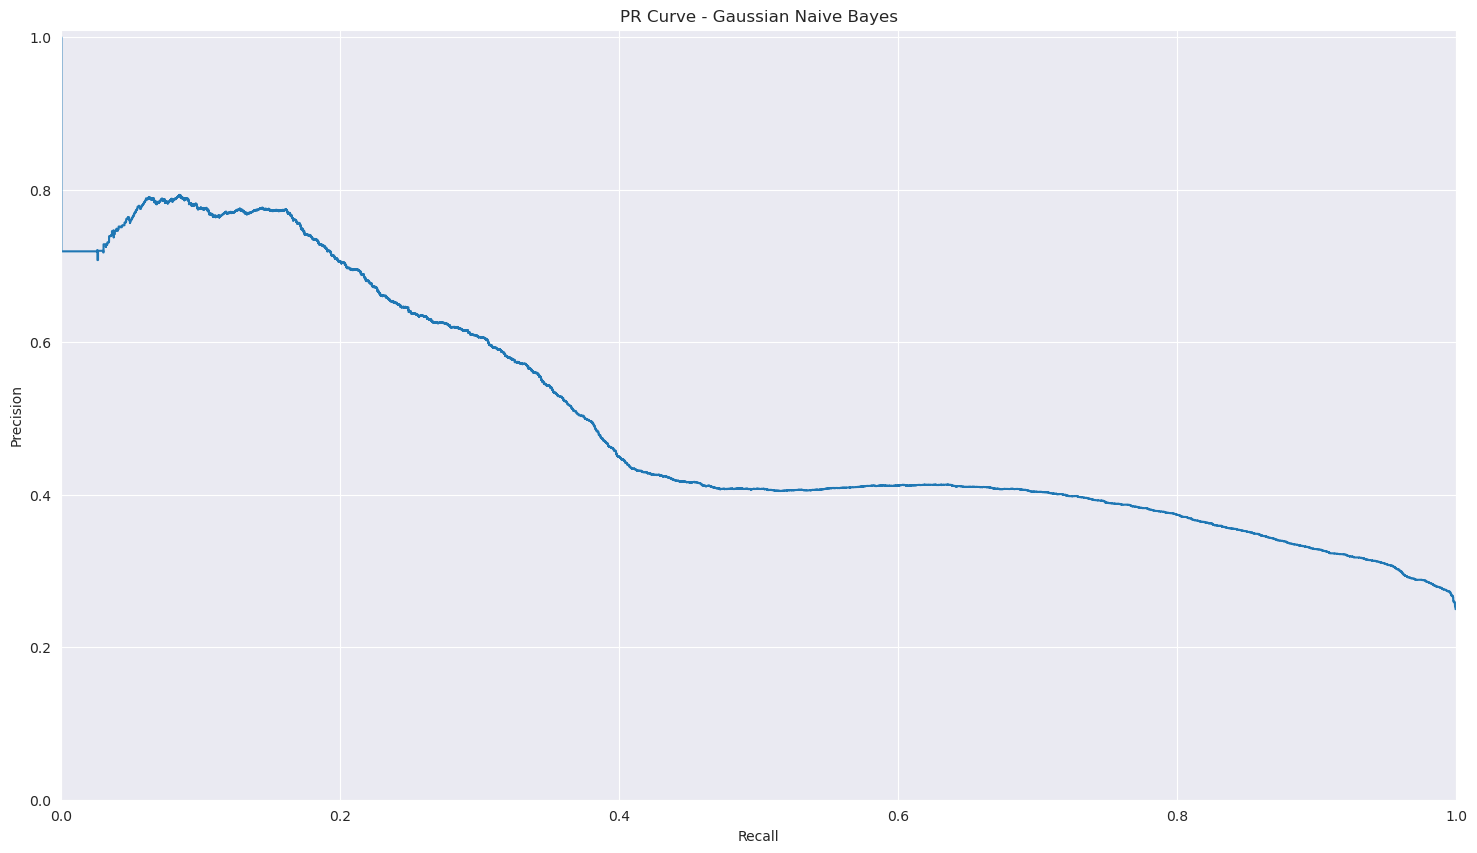

In [318]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = gnb.predict_proba(X_val_sample)

precision["Gaussian Naive Bayes"], recall["Gaussian Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Gaussian Naive Bayes"], tpr["Gaussian Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Gaussian Naive Bayes"], precision["Gaussian Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Gaussian Naive Bayes")
plt.show()

#### Gaussian Naive Bayes ROC Curve on Validation set

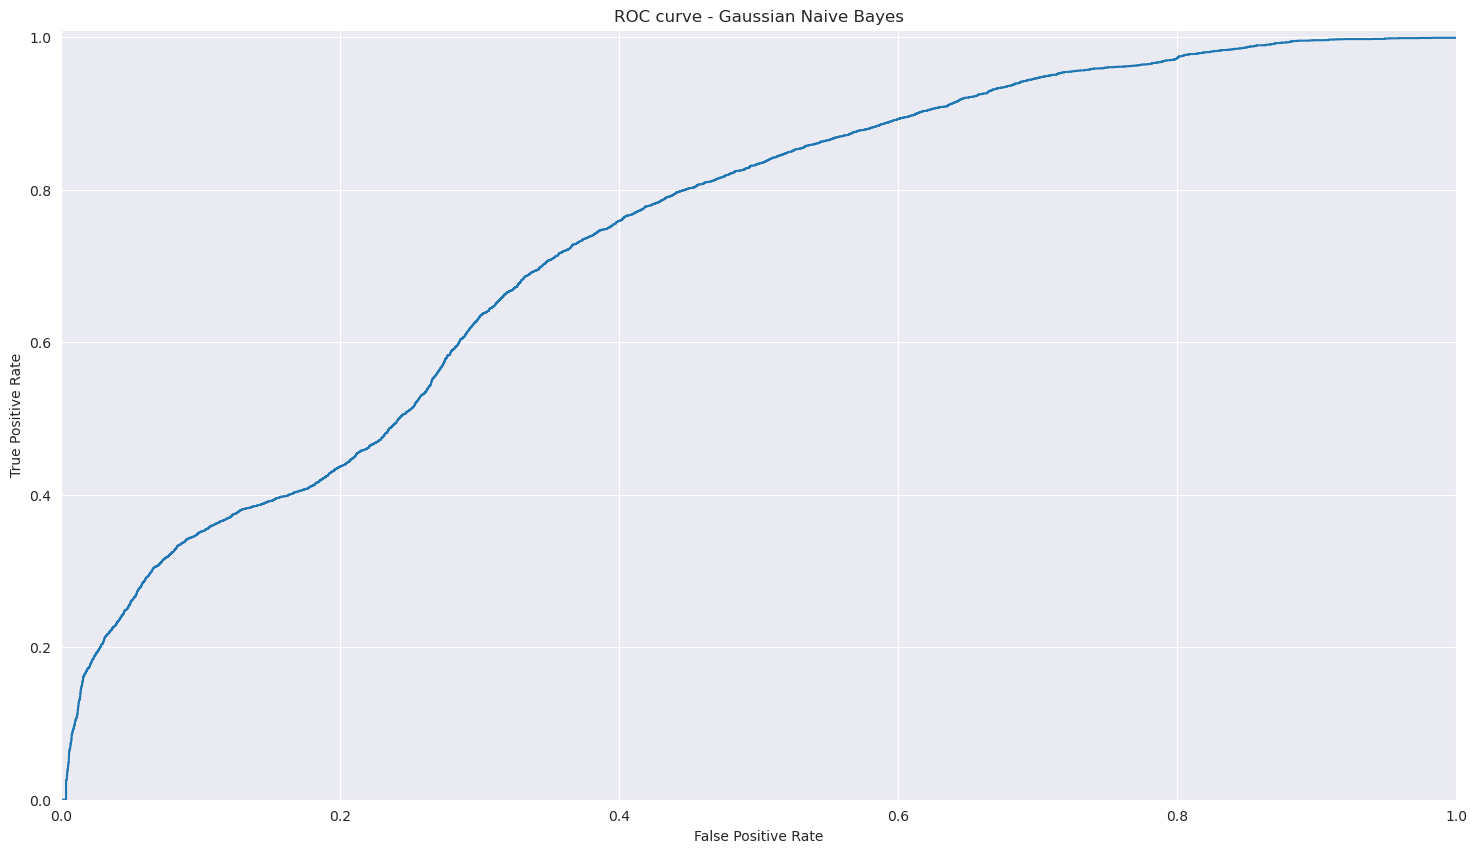

In [319]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Gaussian Naive Bayes"], tpr["Gaussian Naive Bayes"], where="post")

plt.title("ROC curve - Gaussian Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

### Multinomial Naive Bayes

#### Running algo without Grid-Search CV
- There are not major hyper params to be tweaked for this algo.

In [320]:
mnb = MultinomialNB()
mnb.fit(X_train_sample, y_train_sample)

# Storing the model trained with best params later used for visualizations
models["Multinomial Naive Bayes"] = mnb

print("Train score:", mnb.score(X_train_sample, y_train_sample))
print("Validation score:", mnb.score(X_val_sample, y_val_sample))

Train score: 0.6055208333333333
Validation score: 0.6039583333333334


#### Multinomial Naive Bayes Conf. Matrix on Validation set

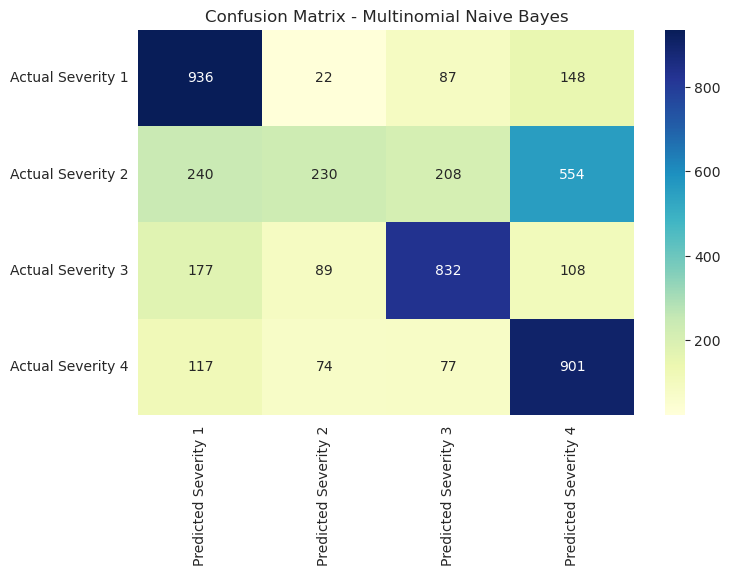

In [321]:
y_pred = mnb.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()

#### Metrics Scores and Metric Visualizations for Multinomial Naive Bayes with best params

In [322]:
y_pred = mnb.predict(X_val_sample)

accuracy["Multinomial Naive Bayes"] = accuracy_score(y_val_sample, y_pred)
f1["Multinomial Naive Bayes"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, mnb.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.80      0.70      4822
           2       0.55      0.18      0.28      4734
           3       0.69      0.68      0.68      4865
           4       0.55      0.75      0.63      4779

    accuracy                           0.61     19200
   macro avg       0.60      0.60      0.57     19200
weighted avg       0.60      0.61      0.57     19200

              precision    recall  f1-score   support

           1       0.64      0.78      0.70      1193
           2       0.55      0.19      0.28      1232
           3       0.69      0.69      0.69      1206
           4       0.53      0.77      0.63      1169

    accuracy                           0.60      4800
   macro avg       0.60      0.61      0.57      4800
weighted avg       0.60      0.60      0.57      4800



#### Multinomial Naive Bayes Precision vs Recall Curve on Validation set

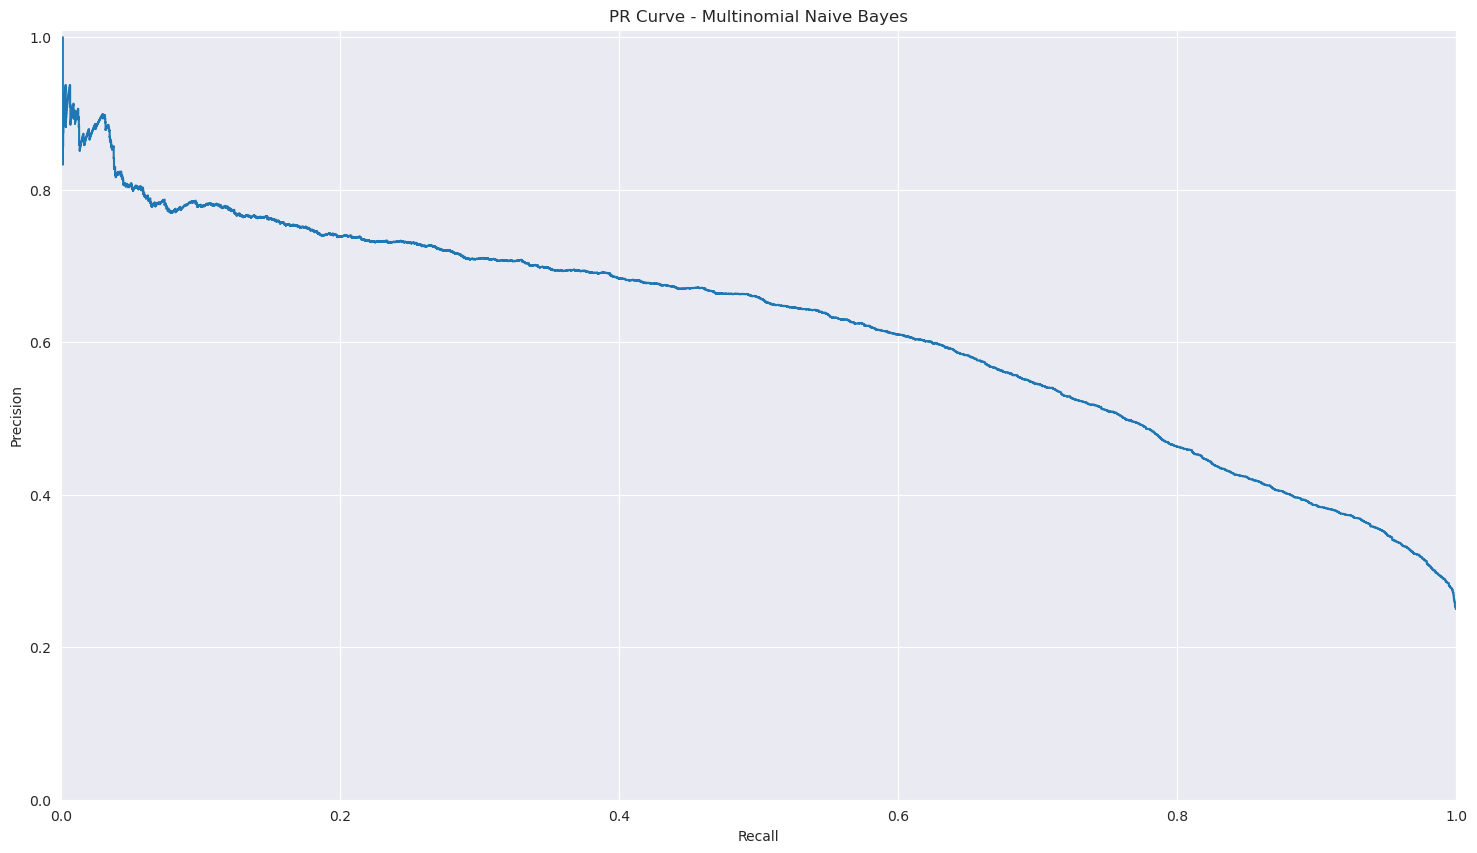

In [323]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = mnb.predict_proba(X_val_sample)

precision["Multinomial Naive Bayes"], recall["Multinomial Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Multinomial Naive Bayes"], precision["Multinomial Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Multinomial Naive Bayes")
plt.show()

#### Multinomial Naive Bayes ROC Curve on Validation set

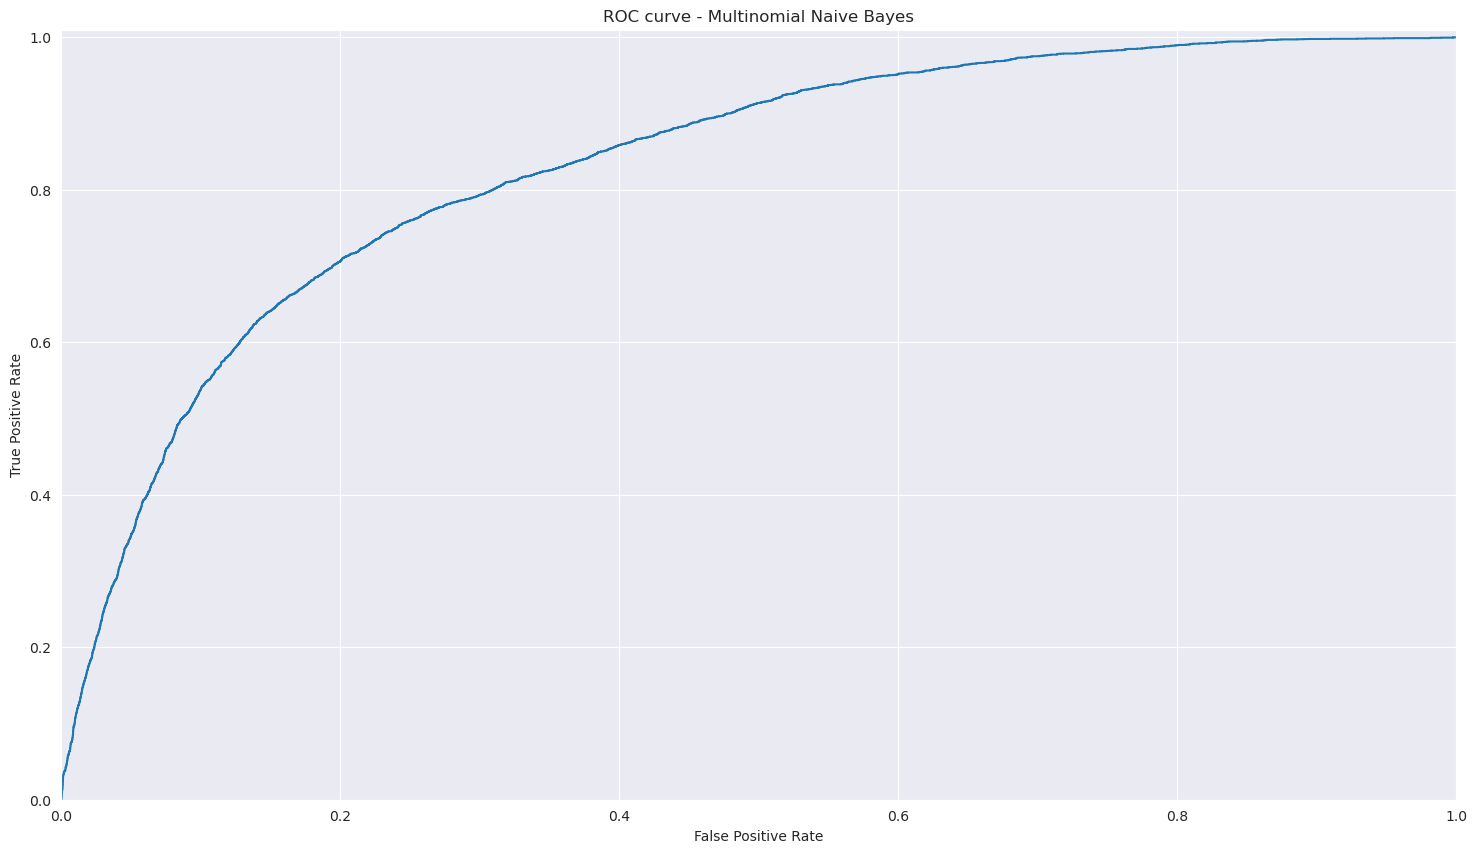

In [324]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], where="post")

plt.title("ROC curve - Multinomial Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

### Bernoulli Naive Bayes

#### Running algo without Grid-Search CV
- There are not major hyper params to be tweaked for this algo.

In [325]:
bnb = BernoulliNB()
bnb.fit(X_train_sample, y_train_sample)

# Storing the model trained with best params later used for visualizations
models["Bernoulli Naive Bayes"] = bnb

print("Train score:", bnb.score(X_train_sample, y_train_sample))
print("Validation score:", bnb.score(X_val_sample, y_val_sample))

Train score: 0.611875
Validation score: 0.6035416666666666


#### Bernoulli Naive Bayes Conf. Matrix on Validation set

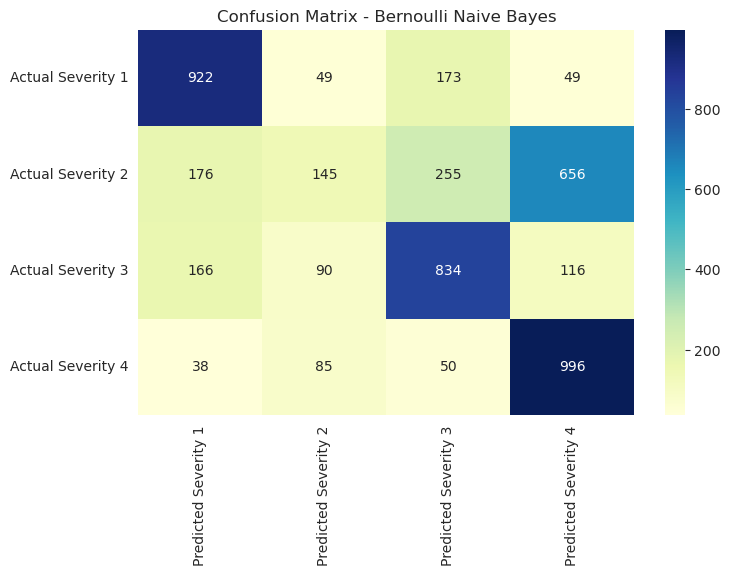

In [326]:
y_pred = bnb.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Bernoulli Naive Bayes")
plt.show()

#### Metrics Scores and Metric Visualizations for Bernoulli Naive Bayes with best params

In [327]:
y_pred = bnb.predict(X_val_sample)

accuracy["Bernoulli Naive Bayes"] = accuracy_score(y_val_sample, y_pred)
f1["Bernoulli Naive Bayes"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, bnb.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.77      0.74      4822
           2       0.40      0.12      0.19      4734
           3       0.63      0.70      0.66      4865
           4       0.57      0.85      0.68      4779

    accuracy                           0.61     19200
   macro avg       0.58      0.61      0.57     19200
weighted avg       0.58      0.61      0.57     19200

              precision    recall  f1-score   support

           1       0.71      0.77      0.74      1193
           2       0.39      0.12      0.18      1232
           3       0.64      0.69      0.66      1206
           4       0.55      0.85      0.67      1169

    accuracy                           0.60      4800
   macro avg       0.57      0.61      0.56      4800
weighted avg       0.57      0.60      0.56      4800



#### Bernoulli Naive Bayes Precision vs Recall Curve on Validation set

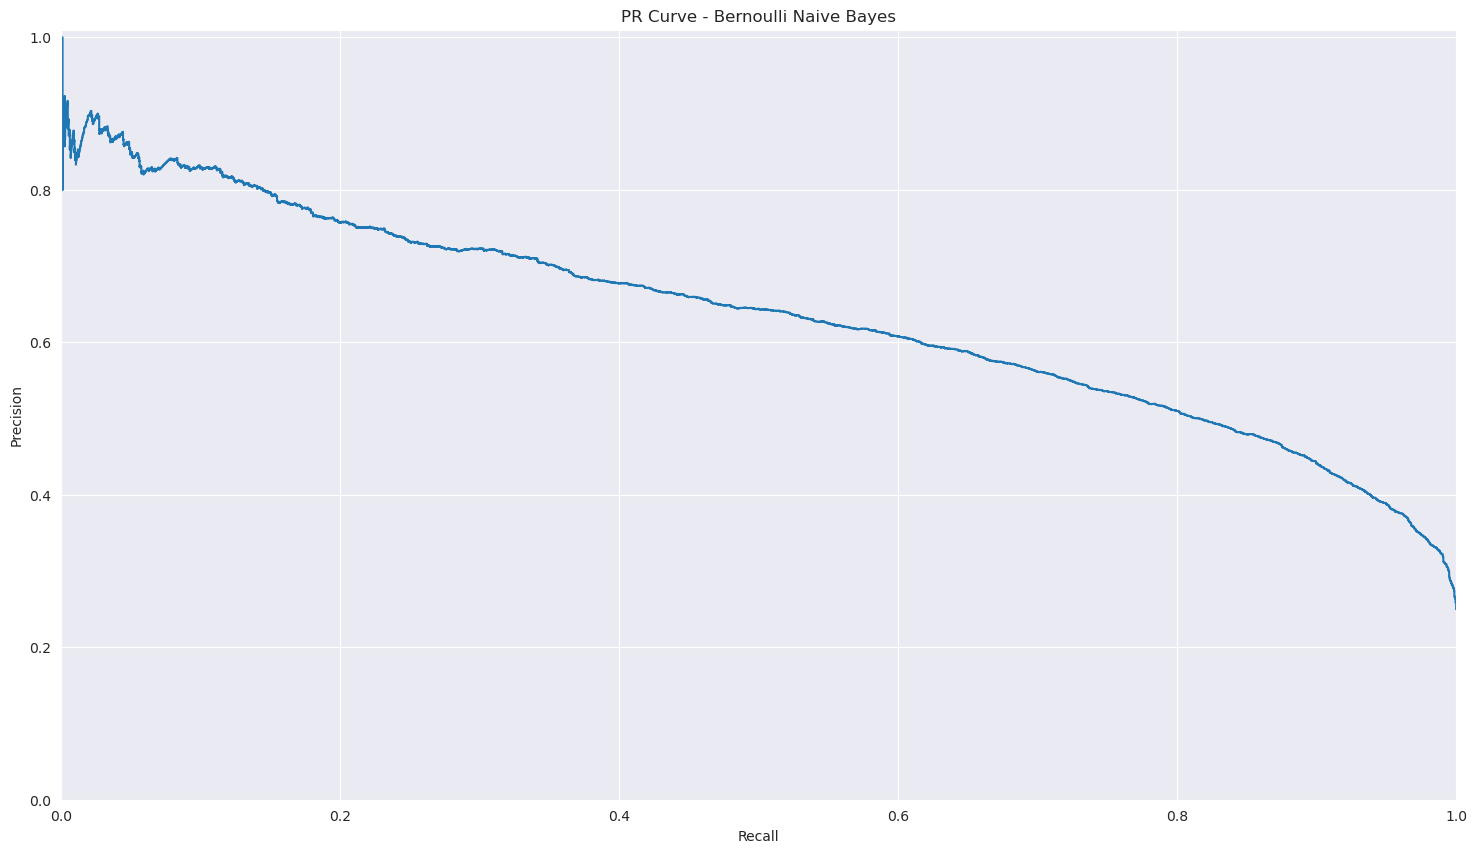

In [328]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = bnb.predict_proba(X_val_sample)

precision["Bernoulli Naive Bayes"], recall["Bernoulli Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Bernoulli Naive Bayes"], tpr["Bernoulli Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Bernoulli Naive Bayes"], precision["Bernoulli Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Bernoulli Naive Bayes")
plt.show()

#### Bernoulli Naive Bayes ROC Curve on Validation set

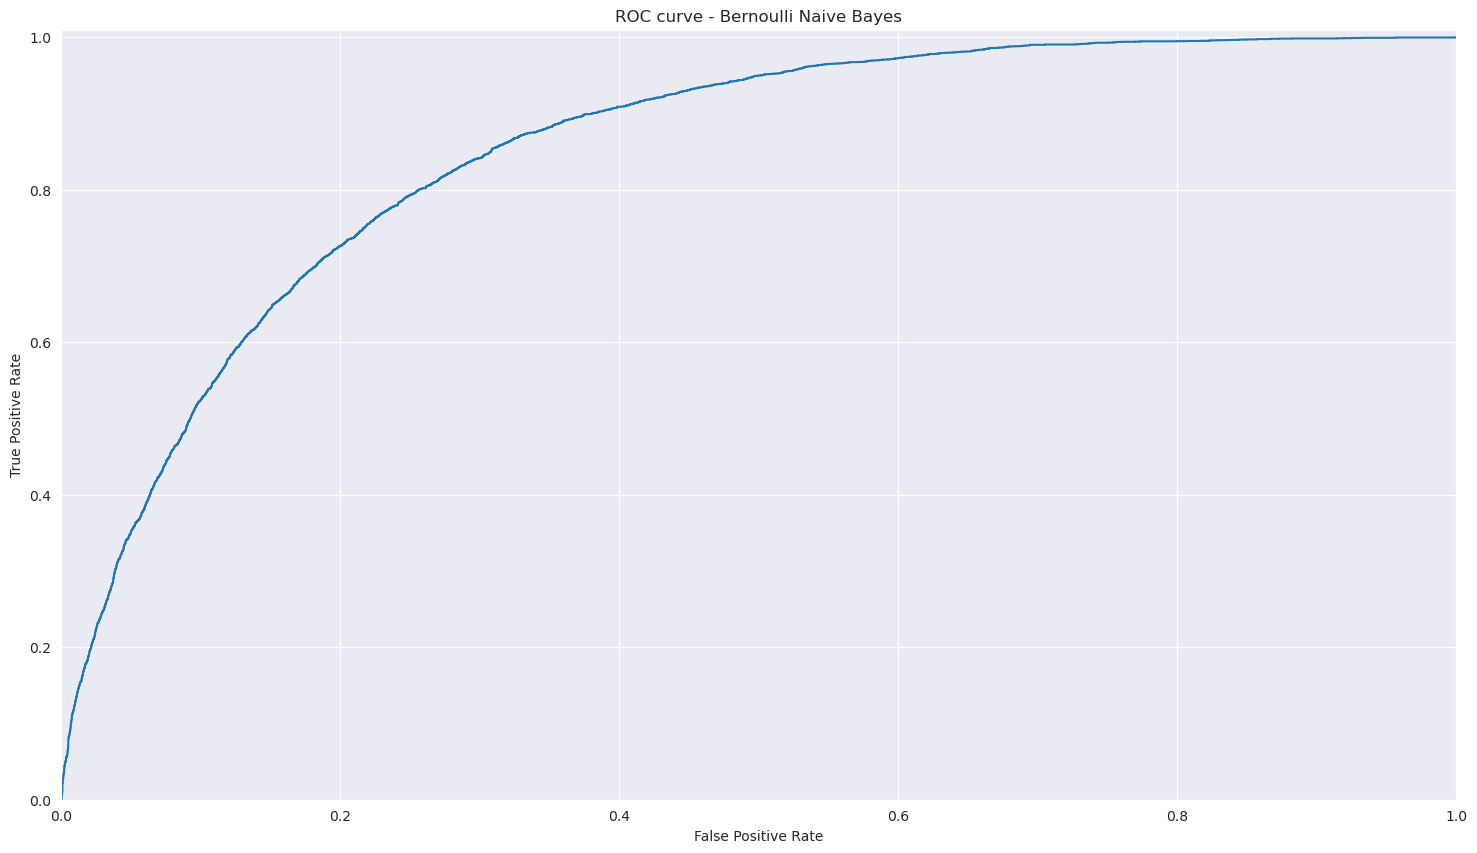

In [329]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Bernoulli Naive Bayes"], tpr["Bernoulli Naive Bayes"], where="post")

plt.title("ROC curve - Bernoulli Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

### XGBoost Classifier
- This algo requires the target labels to start from 0 so we transform the target
| Original Label | Encoded Label |
| -------------- | ------------- |
|       1        |       0       |
|       2        |       1       |
|       3        |       2       |
|       4        |       3       |


In [330]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train_encoded = label_encoder.fit_transform(y_train_sample)
y_val_encoded = label_encoder.transform(y_val_sample)



parameters = [
    {'learning_rate': [0.1, 0.01, 0.05],
     'subsample': [0.6,0.8,0.9],
     'n_estimators': [16,64,128]}
]

xgb = XGBClassifier(tree_method = 'gpu_hist',random_state=42)
grid = GridSearchCV(xgb, parameters, verbose=0, n_jobs=-1)
grid.fit(X_train_sample, y_train_encoded)

print("Best parameters scores:")
print(grid.best_params_)
best_params["xgb"] = grid.best_params_
print("Train score: ", grid.score(X_train_sample, y_train_encoded))

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters scores:
{'learning_rate': 0.1, 'n_estimators': 128, 'subsample': 0.9}
Train score:  0.8716145833333333


In [331]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,3.067073,0.128407,0.077126,0.001278,0.1,128,0.9,"{'learning_rate': 0.1, 'n_estimators': 128, 's...",0.800521,0.792708,0.786979,0.801823,0.793750,0.795156,0.005442,1
7,3.132010,0.157575,0.077569,0.000420,0.1,128,0.8,"{'learning_rate': 0.1, 'n_estimators': 128, 's...",0.800521,0.792969,0.788542,0.797917,0.790885,0.794167,0.004434,2
6,3.214932,0.094857,0.077695,0.001827,0.1,128,0.6,"{'learning_rate': 0.1, 'n_estimators': 128, 's...",0.796875,0.791146,0.788802,0.794792,0.794010,0.793125,0.002837,3
25,3.262971,0.023262,0.081692,0.006806,0.05,128,0.8,"{'learning_rate': 0.05, 'n_estimators': 128, '...",0.796615,0.789844,0.781510,0.796875,0.788542,0.790677,0.005709,4
24,3.273804,0.056599,0.078601,0.002916,0.05,128,0.6,"{'learning_rate': 0.05, 'n_estimators': 128, '...",0.794531,0.791146,0.779167,0.797396,0.789583,0.790365,0.006220,5
26,2.902239,0.472337,0.090681,0.035054,0.05,128,0.9,"{'learning_rate': 0.05, 'n_estimators': 128, '...",0.793750,0.788021,0.780729,0.796094,0.789062,0.789531,0.005307,6
5,1.885446,0.033292,0.046460,0.002780,0.1,64,0.9,"{'learning_rate': 0.1, 'n_estimators': 64, 'su...",0.792969,0.788802,0.779687,0.794010,0.789583,0.789010,0.005059,7
4,1.903320,0.040210,0.046029,0.002750,0.1,64,0.8,"{'learning_rate': 0.1, 'n_estimators': 64, 'su...",0.791146,0.789323,0.779687,0.794531,0.786979,0.788333,0.004978,8
3,1.908362,0.046139,0.048469,0.002625,0.1,64,0.6,"{'learning_rate': 0.1, 'n_estimators': 64, 'su...",0.790365,0.787760,0.782031,0.790625,0.788021,0.787760,0.003094,9
23,1.799945,0.035620,0.043470,0.001835,0.05,64,0.9,"{'learning_rate': 0.05, 'n_estimators': 64, 's...",0.785677,0.781510,0.778385,0.792188,0.780208,0.783594,0.004922,10


#### Running the best params XGB Model

In [332]:
print("Best Param scores for XGB:")
xgb = XGBClassifier(**grid.best_params_,random_state=42)

xgb.fit(X_train_sample, y_train_encoded)
# Storing the model trained with best params later used for visualizations
models["XGB Classifier"] = xgb

print("Train Score: ", xgb.score(X_train_sample, y_train_encoded))
print("Validation Score: ", xgb.score(X_val_sample, y_val_encoded))

Best Param scores for XGB:
Train Score:  0.8707291666666667
Validation Score:  0.795


#### XGB Conf. Matrix on Validation Set

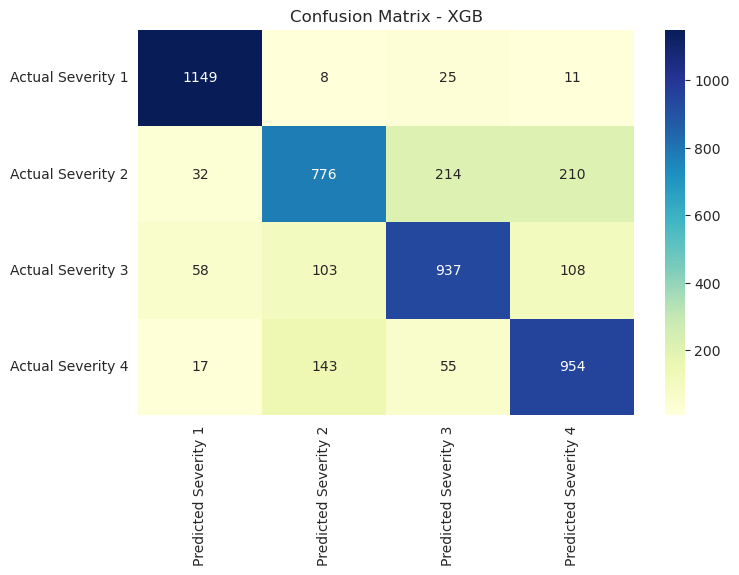

In [333]:
y_pred = xgb.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_encoded, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - XGB")
plt.show()

#### Metrics Scores and Metric Visualizations for XGB with best params

In [334]:
y_pred = xgb.predict(X_val_sample)

accuracy["XGB"] = accuracy_score(y_val_encoded, y_pred)
f1["XGB"] = f1_score(y_val_encoded, y_pred, average="macro")

print(classification_report(y_train_encoded, xgb.predict(X_train_sample)))
print(classification_report(y_val_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      4822
           1       0.86      0.74      0.80      4734
           2       0.84      0.87      0.86      4865
           3       0.84      0.89      0.86      4779

    accuracy                           0.87     19200
   macro avg       0.87      0.87      0.87     19200
weighted avg       0.87      0.87      0.87     19200

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1193
           1       0.75      0.63      0.69      1232
           2       0.76      0.78      0.77      1206
           3       0.74      0.82      0.78      1169

    accuracy                           0.80      4800
   macro avg       0.79      0.80      0.79      4800
weighted avg       0.79      0.80      0.79      4800



#### XGB Precision vs Recall Curve on Validation Set

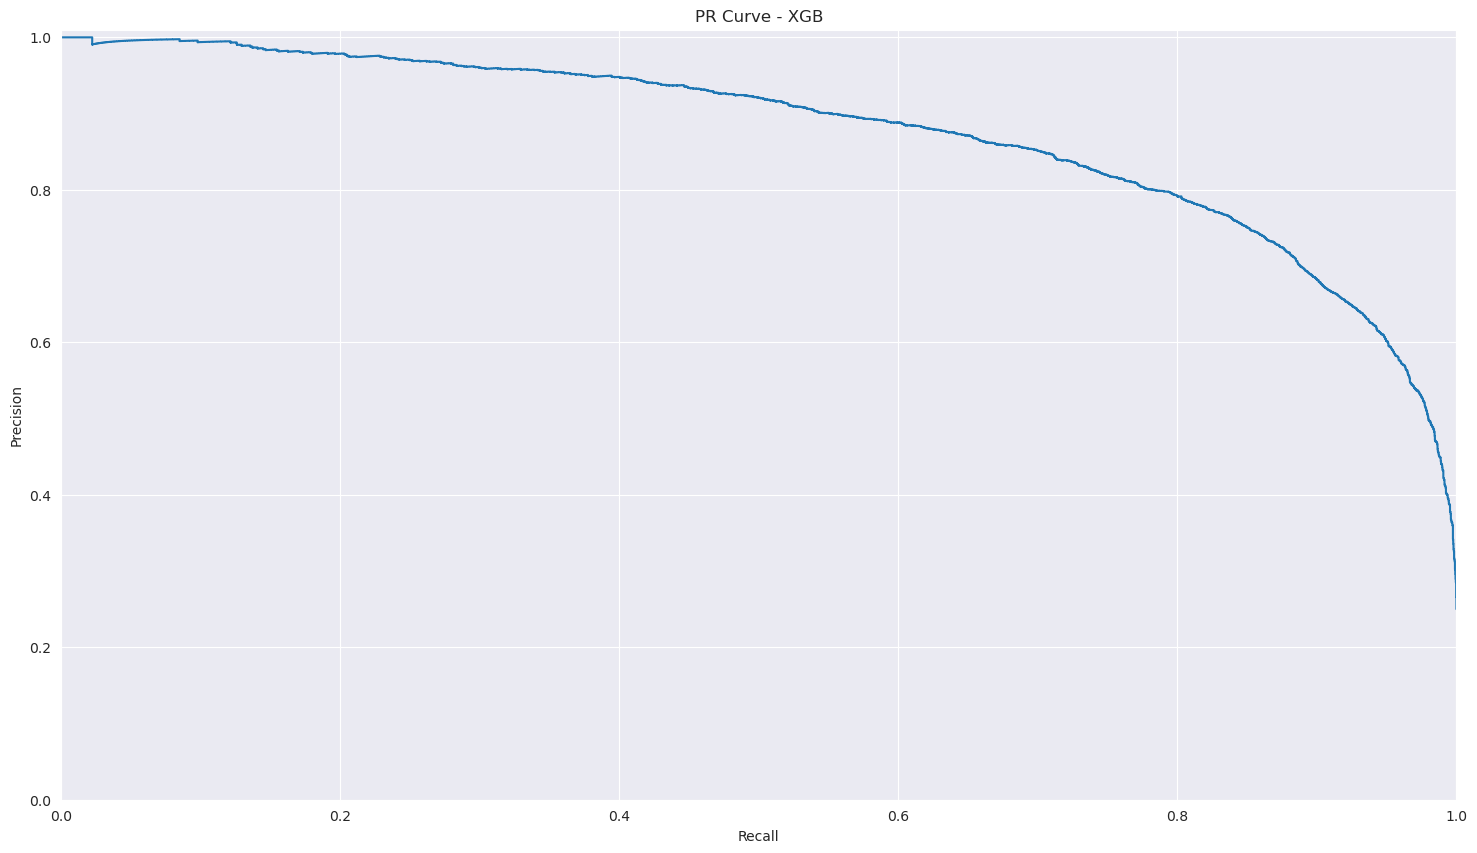

In [335]:
Y = label_binarize(y_val_encoded, classes=[0, 1, 2, 3])

y_score = xgb.predict_proba(X_val_sample)

precision["XGB"], recall["XGB"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["XGB"], tpr["XGB"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["XGB"], precision["XGB"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - XGB")
plt.show()

#### XGB ROC Curve on Validation Set

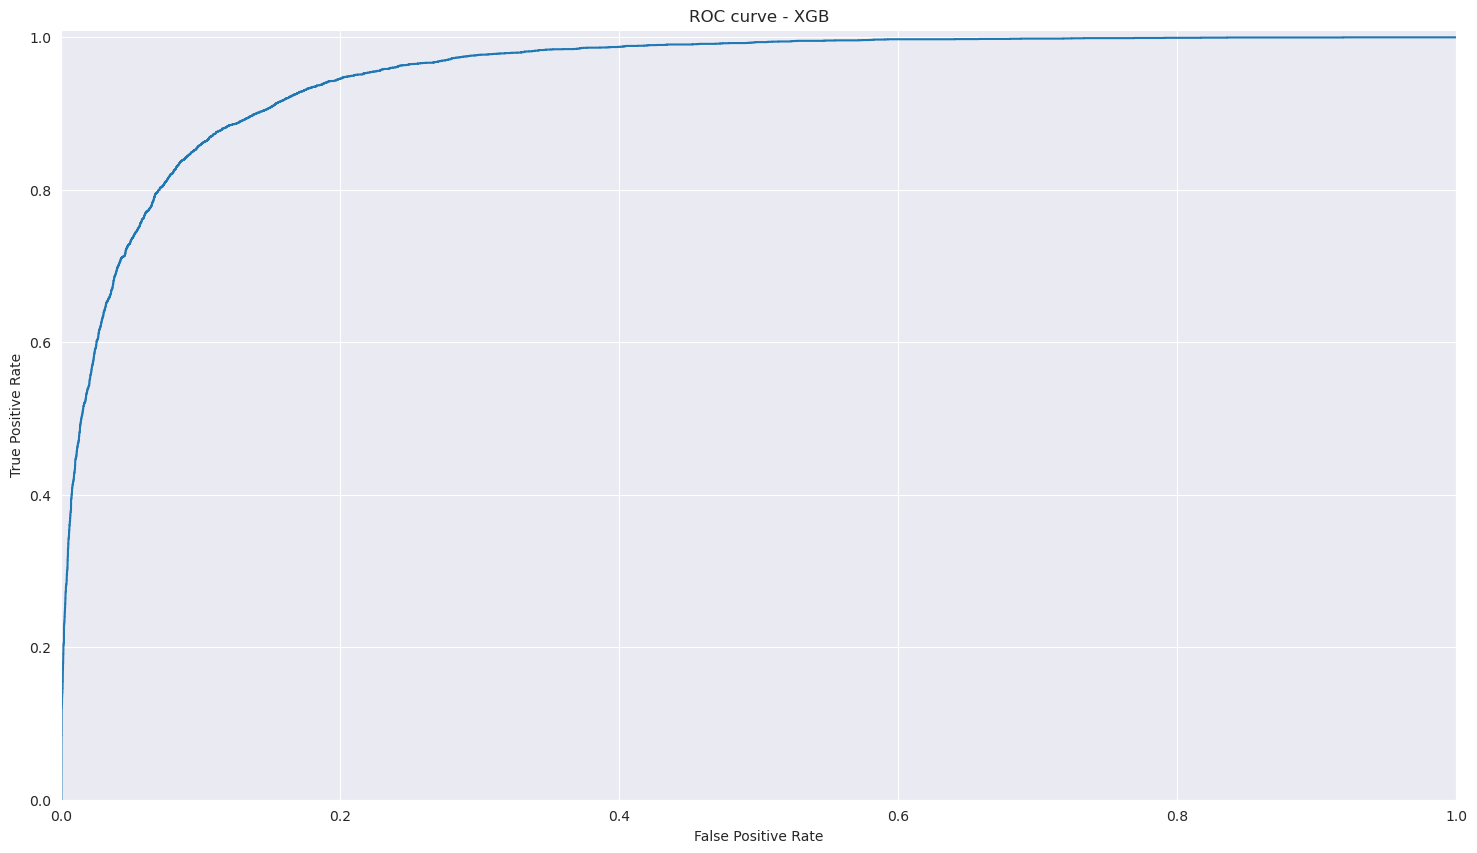

In [336]:
plt.figure(figsize=(18, 10))
plt.step(fpr["XGB"], tpr["XGB"], where="post")

plt.title("ROC curve - XGB")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

### Multi Layer Perceptron

#### Multi Layer Perceptron Grid Search CV (5 - folds) Run to find best params

In [337]:
mlp = MLPClassifier(random_state=42, verbose=False)
parameters = [{"hidden_layer_sizes": [(64, 32), (32, 64, 32)], "max_iter": [200], "solver": ["sgd", "adam"], "activation": ["tanh", "relu"]}]
grid = GridSearchCV(mlp, parameters, verbose = 0, n_jobs=-1)

grid.fit(X_train_sample, y_train_sample)

print("Best parameters scores:")
print(grid.best_params_)
best_params["mlp"] = grid.best_params_
print("Train score:", grid.score(X_train_sample, y_train_sample))
print("Validation score:", grid.score(X_val_sample, y_val_sample))

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Best parameters scores:
{'activation': 'tanh', 'hidden_layer_sizes': (64, 32), 'max_iter': 200, 'solver': 'adam'}
Train score: 0.8189583333333333
Validation score: 0.7510416666666667


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [338]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,19.106705,0.435495,0.009255,0.000457,tanh,"(64, 32)",200,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.756250,0.752865,0.740885,0.762500,0.755208,0.753542,0.007085,1
6,22.971275,0.389052,0.008846,0.000471,relu,"(32, 64, 32)",200,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.754167,0.746615,0.741146,0.761458,0.757812,0.752240,0.007409,2
3,23.115873,0.363470,0.010795,0.002369,tanh,"(32, 64, 32)",200,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.742969,0.749740,0.746354,0.761458,0.754687,0.751042,0.006491,3
2,20.719785,0.305517,0.009857,0.000625,tanh,"(32, 64, 32)",200,sgd,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.748958,0.743490,0.734635,0.752604,0.757812,0.747500,0.007951,4
5,24.164772,0.728618,0.011189,0.004261,relu,"(64, 32)",200,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.742708,0.752344,0.733333,0.754167,0.737760,0.744062,0.008091,5
4,19.729288,0.366591,0.009005,0.000415,relu,"(64, 32)",200,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.744531,0.736198,0.731510,0.751563,0.747396,0.742240,0.007354,6
7,28.641310,3.188170,0.009927,0.002859,relu,"(32, 64, 32)",200,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.749740,0.742188,0.734375,0.745313,0.738542,0.742031,0.005310,7
0,16.518863,0.566479,0.011748,0.003198,tanh,"(64, 32)",200,sgd,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.730729,0.725260,0.714323,0.737760,0.732812,0.728177,0.008004,8


#### Running the best params Multi Layer Perceptron Model

In [339]:
print("Best Param scores for Multi Layer Perceptron:")
mlp = MLPClassifier(**grid.best_params_, random_state=42)

mlp.fit(X_train_sample, y_train_sample)
# Storing the model trained with best params later used for visualizations
models["Multi Layer Perceptron"] = mlp

print("Train Score: ", mlp.score(X_train_sample, y_train_sample))
print("Validation Score: ", mlp.score(X_val_sample, y_val_sample))

Best Param scores for Multi Layer Perceptron:
Train Score:  0.8189583333333333
Validation Score:  0.7510416666666667


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Multi Layer Perceptron Conf. Matrix on Validation Set

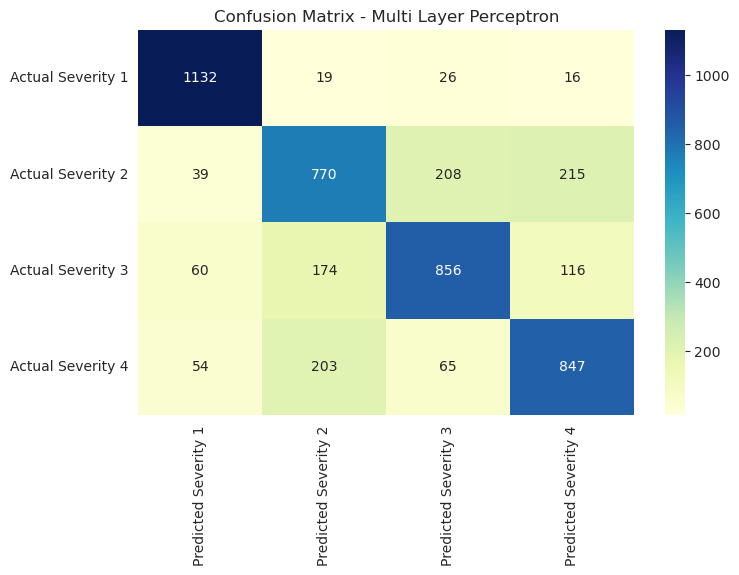

In [340]:
y_pred = mlp.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Multi Layer Perceptron")
plt.show()

#### Metrics Scores and Metric Visualizations for Multi Layer Perceptron with best params

In [341]:
y_pred = mlp.predict(X_val_sample)

accuracy["Multi Layer Perceptron"] = accuracy_score(y_val_sample, y_pred)
f1["Multi Layer Perceptron"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, mlp.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       0.91      0.97      0.94      4822
           2       0.75      0.72      0.73      4734
           3       0.80      0.79      0.80      4865
           4       0.81      0.79      0.80      4779

    accuracy                           0.82     19200
   macro avg       0.82      0.82      0.82     19200
weighted avg       0.82      0.82      0.82     19200

              precision    recall  f1-score   support

           1       0.88      0.95      0.91      1193
           2       0.66      0.62      0.64      1232
           3       0.74      0.71      0.73      1206
           4       0.71      0.72      0.72      1169

    accuracy                           0.75      4800
   macro avg       0.75      0.75      0.75      4800
weighted avg       0.75      0.75      0.75      4800



#### Multi Layer Perceptron Precision vs Recall Curve on Validation Set

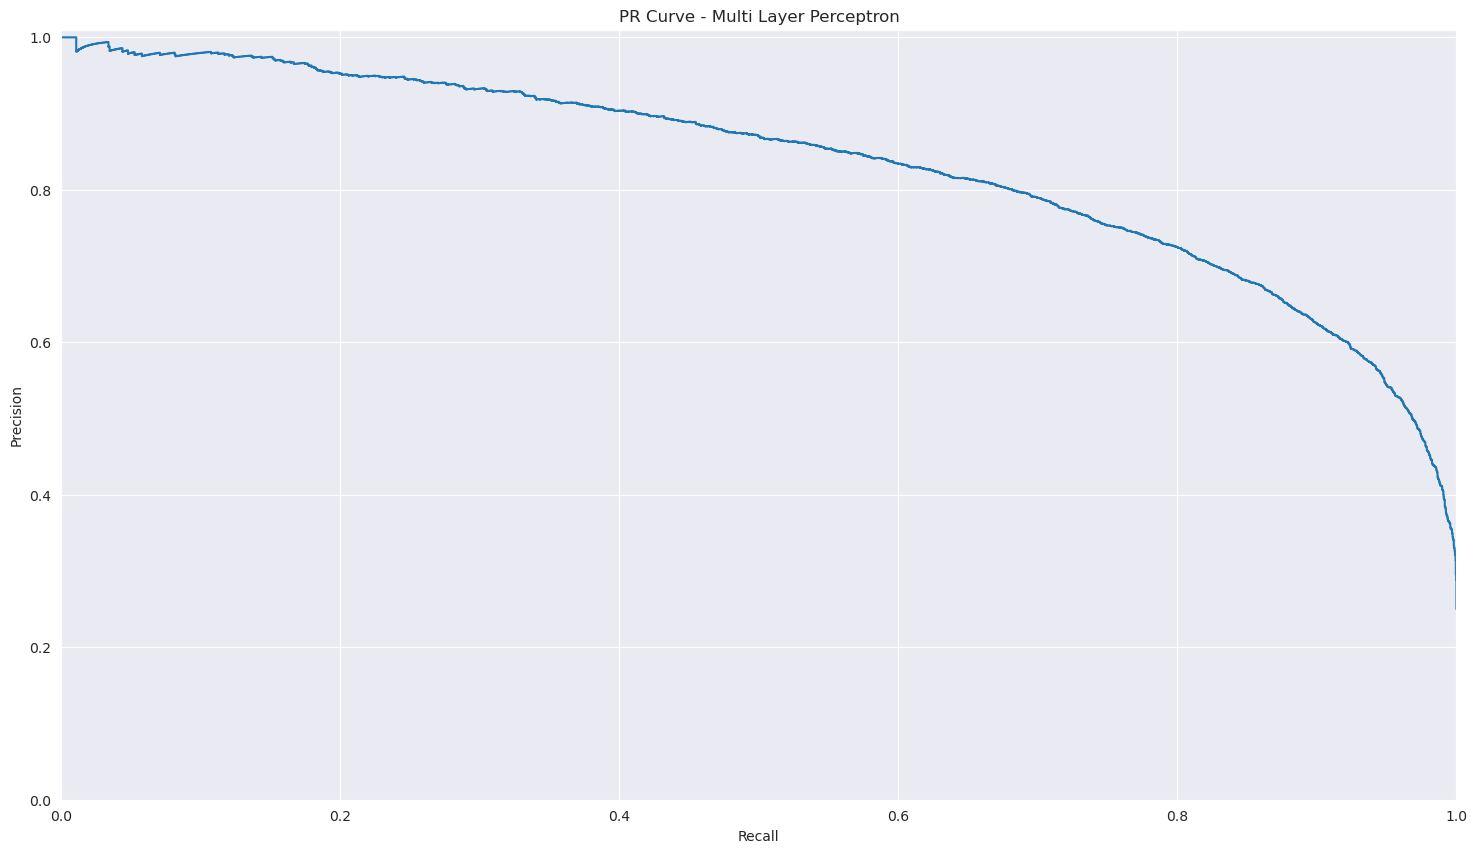

In [342]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = mlp.predict_proba(X_val_sample)

precision["Multi Layer Perceptron"], recall["Multi Layer Perceptron"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Multi Layer Perceptron"], tpr["Multi Layer Perceptron"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Multi Layer Perceptron"], precision["Multi Layer Perceptron"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Multi Layer Perceptron")
plt.show()

#### Multi Layer Perceptron ROC Curve on Validation Set

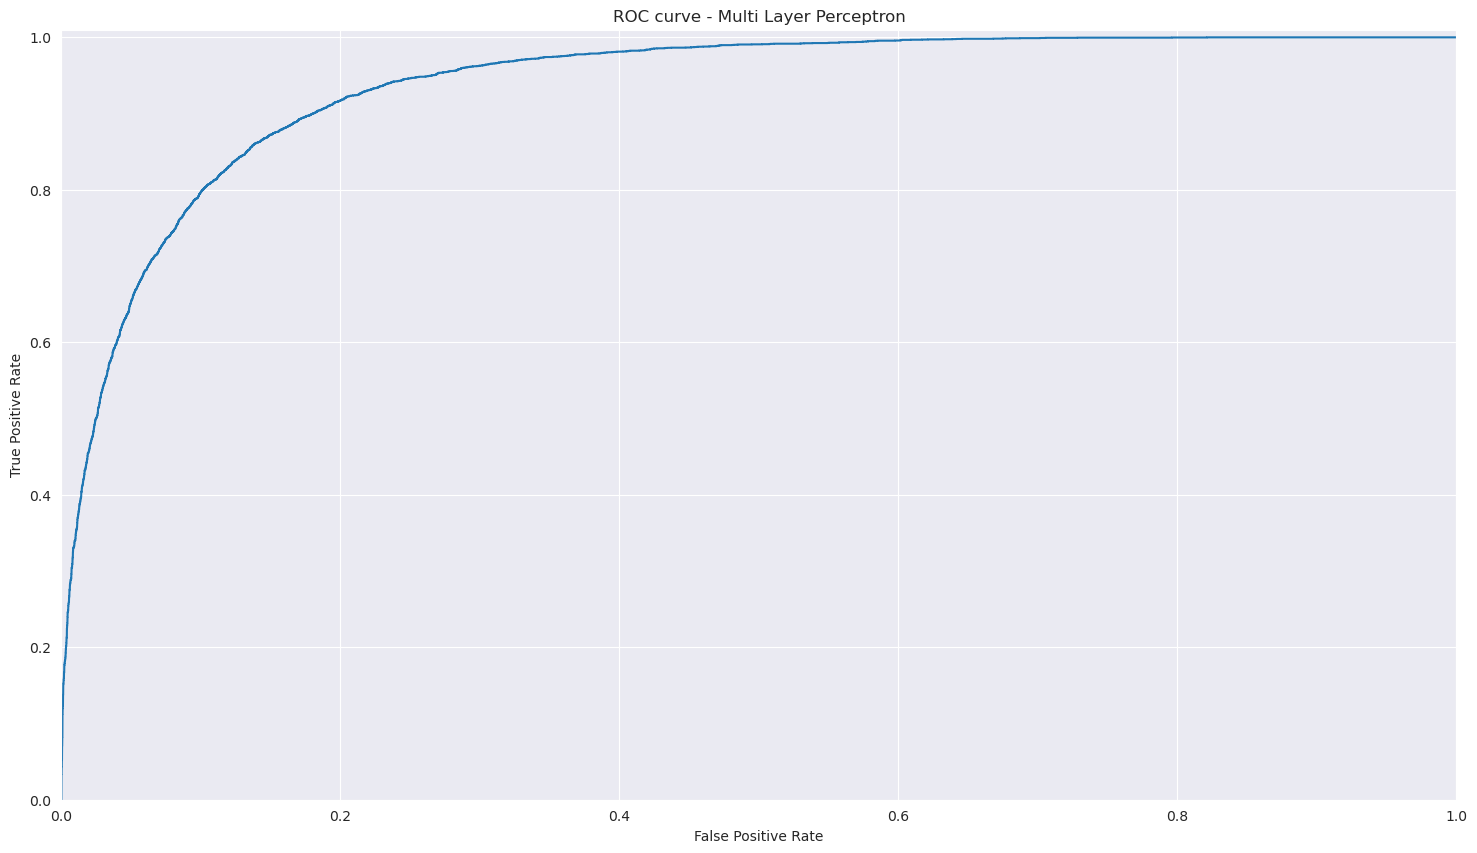

In [343]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Multi Layer Perceptron"], tpr["Multi Layer Perceptron"], where="post")

plt.title("ROC curve - Multi Layer Perceptron")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

### Support Vector Machine

#### Grid Search CV(5-folds) RUN to find best Params 

In [344]:
parameters = [{"kernel": ["linear", "rbf", "sigmoid"], "C": [.2, .5, .8, 1.]}, {"kernel": ["poly"], "C": [.2, .5, .8, 1.], "degree": [2, 3, 4]}]
svc = svm.SVC(verbose = 0, random_state = 42, shrinking = False)
grid = GridSearchCV(svc, parameters, verbose = 0, n_jobs = -1)

grid.fit(X_sample_train,y_sample_train)
print("Best parameters scores:")
print(grid.best_params_)
best_params["svc"] = grid.best_params_
print("Train score: ", grid.score(X_sample_train, y_sample_train))

Best parameters scores:
{'C': 1.0, 'kernel': 'rbf'}
Train score:  0.7429166666666667


In [345]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,32.260032,0.143948,8.945977,0.487535,1.0,rbf,NaN,"{'C': 1.0, 'kernel': 'rbf'}",0.732500,0.729792,0.716875,0.716875,0.737708,0.726750,0.008455,1
23,27.574225,4.497365,3.685331,0.800828,1.0,poly,4,"{'C': 1.0, 'degree': 4, 'kernel': 'poly'}",0.734375,0.731042,0.716875,0.716250,0.728125,0.725333,0.007432,2
22,26.673938,0.587722,4.095733,0.269865,1.0,poly,3,"{'C': 1.0, 'degree': 3, 'kernel': 'poly'}",0.734583,0.730208,0.714375,0.715833,0.730625,0.725125,0.008336,3
7,31.650738,0.603531,8.659305,0.425884,0.8,rbf,NaN,"{'C': 0.8, 'kernel': 'rbf'}",0.730625,0.727708,0.717292,0.715625,0.733542,0.724958,0.007201,4
20,28.384177,0.358249,4.026727,0.120665,0.8,poly,4,"{'C': 0.8, 'degree': 4, 'kernel': 'poly'}",0.735000,0.728750,0.716250,0.716042,0.727083,0.724625,0.007410,5
19,26.849181,0.535798,3.905945,0.042064,0.8,poly,3,"{'C': 0.8, 'degree': 3, 'kernel': 'poly'}",0.731875,0.727083,0.713333,0.715625,0.727708,0.723125,0.007285,6
17,28.644837,0.279786,4.240965,0.122288,0.5,poly,4,"{'C': 0.5, 'degree': 4, 'kernel': 'poly'}",0.729375,0.725833,0.714583,0.711667,0.724792,0.721250,0.006868,7
4,30.592421,0.220757,8.872729,0.275204,0.5,rbf,NaN,"{'C': 0.5, 'kernel': 'rbf'}",0.727083,0.724375,0.712917,0.711042,0.725417,0.720167,0.006767,8
16,26.924972,0.411861,4.175091,0.081210,0.5,poly,3,"{'C': 0.5, 'degree': 3, 'kernel': 'poly'}",0.728125,0.725208,0.712083,0.710417,0.723542,0.719875,0.007213,9
21,25.660745,0.220622,3.786673,0.033971,1.0,poly,2,"{'C': 1.0, 'degree': 2, 'kernel': 'poly'}",0.728333,0.723333,0.710000,0.710208,0.724583,0.719292,0.007680,10


#### Running the best params SVM model

In [346]:
### We run the model on partial Dataset for fast training and observing the op/s.
print("Best Param scores for SVM:")
svc = svm.SVC(verbose = 0, random_state = 42, shrinking = False, C=1, kernel = 'rbf', degree = 4)

svc.fit(X_train_sample, y_train_sample)
# Storing the model trained with best params later used for visualizations
models["Support Vector Machine"] = svc

print("Train score:", svc.score(X_train_sample, y_train_sample))
print("Validation score:", svc.score(X_val_sample, y_val_sample))

Best Param scores for SVM:
Train score: 0.7433333333333333
Validation score: 0.7204166666666667


#### SVM Conf. Matrix on Validation set

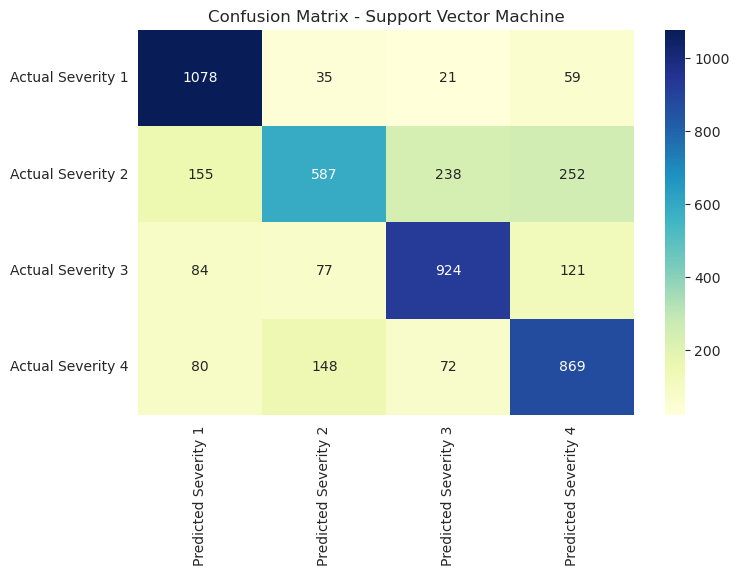

In [347]:
y_pred = svc.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()

#### Metrics Scores and Metric Visualizations for SVM with best params

In [348]:
y_pred = svc.predict(X_val_sample)

accuracy["SVM"] = accuracy_score(y_val_sample, y_pred)
f1["SVM"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, svc.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       0.80      0.91      0.85      4822
           2       0.72      0.50      0.59      4734
           3       0.74      0.80      0.77      4865
           4       0.70      0.76      0.73      4779

    accuracy                           0.74     19200
   macro avg       0.74      0.74      0.73     19200
weighted avg       0.74      0.74      0.74     19200

              precision    recall  f1-score   support

           1       0.77      0.90      0.83      1193
           2       0.69      0.48      0.56      1232
           3       0.74      0.77      0.75      1206
           4       0.67      0.74      0.70      1169

    accuracy                           0.72      4800
   macro avg       0.72      0.72      0.71      4800
weighted avg       0.72      0.72      0.71      4800



#### SVM Precision vs Recall Curve on Validation set

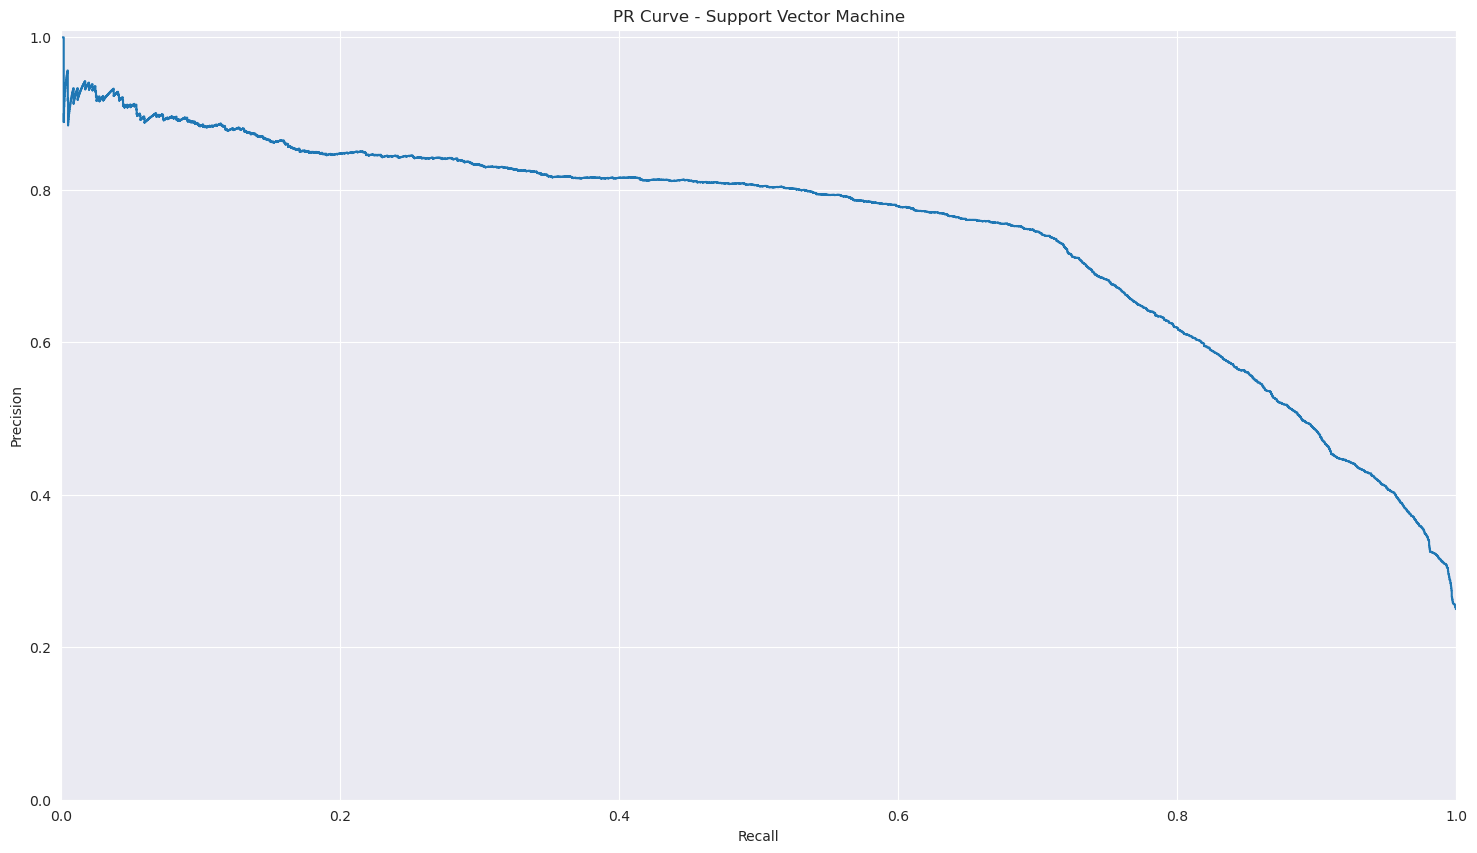

In [349]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = svc.decision_function(X_val_sample)

precision["SVM"], recall["SVM"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["SVM"], tpr["SVM"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["SVM"], precision["SVM"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Support Vector Machine")
plt.show()

#### SVM ROC Curve on Validation set

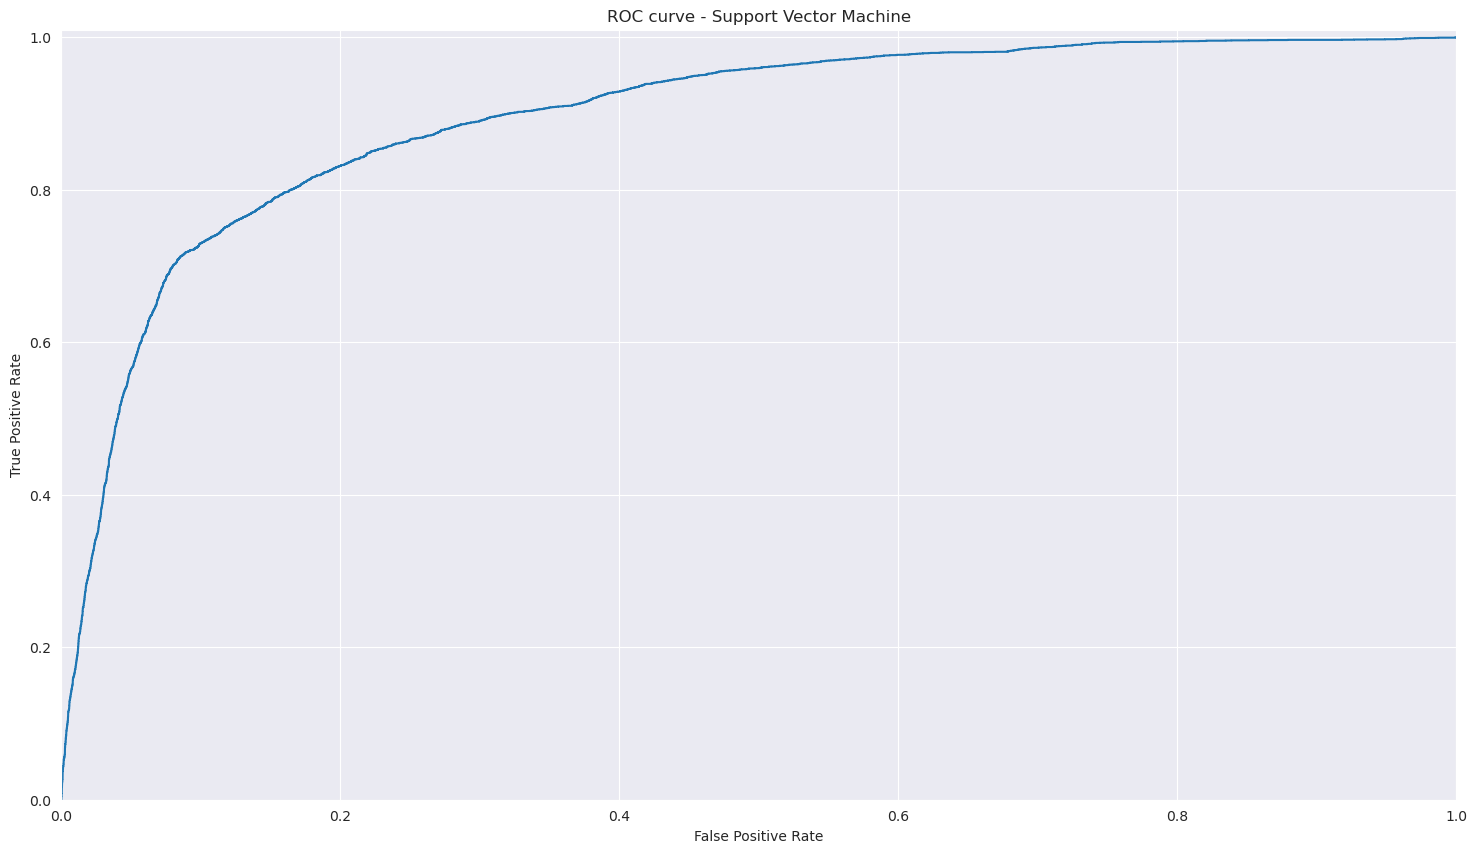

In [350]:
plt.figure(figsize=(18, 10))
plt.step(fpr["SVM"], tpr["SVM"], where="post")

plt.title("ROC curve - Support Vector Machine")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

## Result and Comparisions after Training on Partial Data
- **Partial data is used to train since models like SVM can't train on the whole dataset, efficiently, until Kaggle notebook Time's Out.**
- So we use partial data to train the model and then select the best of these by comparing results on Validation data

#### Accuracy Metric Comparision between Models

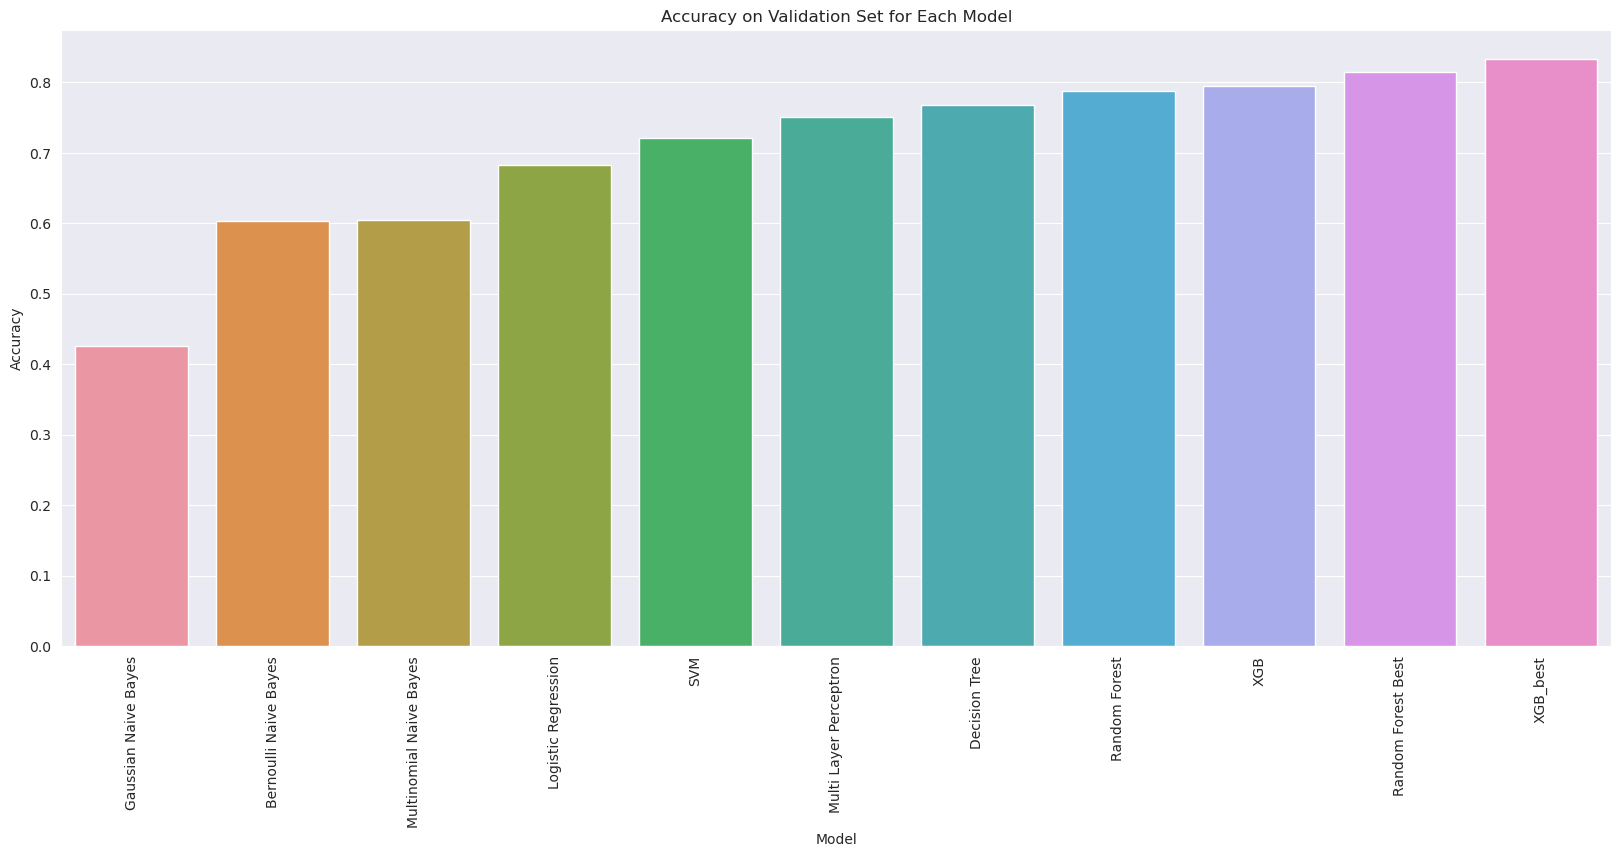

In [377]:
plt.figure(figsize=(20, 8))
plt.title("Accuracy on Validation Set for Each Model")
sorted_accuracy = sorted(accuracy.items(), key=lambda x: x[1])
sorted_labels = [item[0] for item in sorted_accuracy]
sorted_values = [item[1] for item in sorted_accuracy]
sns.barplot(x=sorted_labels, y=sorted_values)
plt.xticks(rotation=90)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.savefig("All_Models_Accuracy_Score_Plot_on_Val_Set.png",bbox_inches = 'tight', dpi = 300)
plt.show()

#### F1-Score Metric Comparision between Models

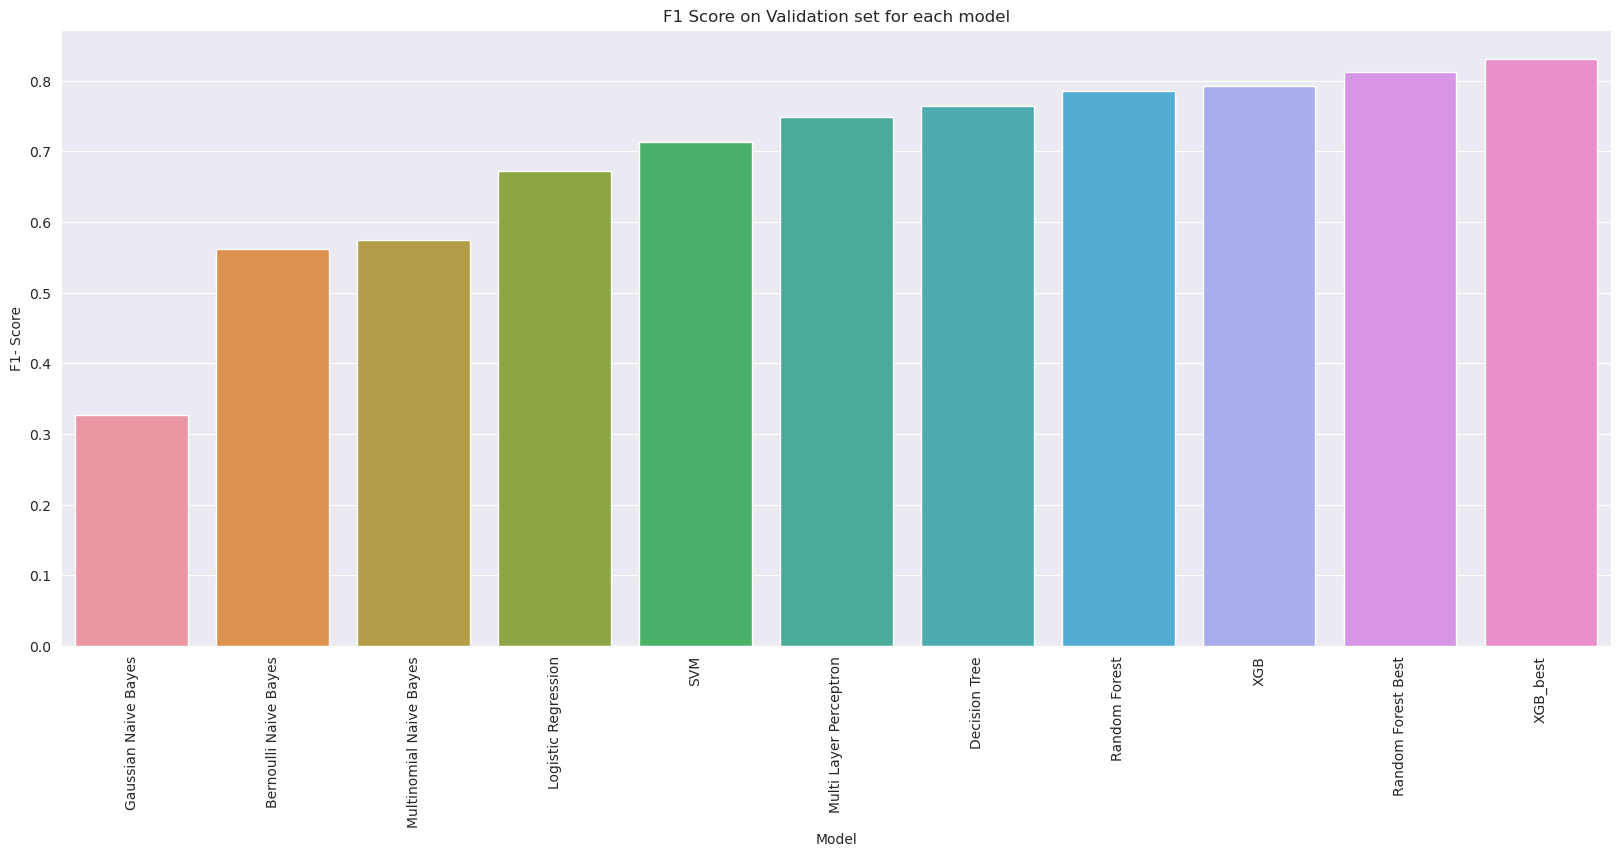

In [378]:
plt.figure(figsize=(20, 8))
plt.title("F1 Score on Validation set for each model")
sorted_f1 = sorted(f1.items(), key=lambda x: x[1])
sorted_labels = [item[0] for item in sorted_f1]
sorted_values = [item[1] for item in sorted_f1]
sns.barplot(x=sorted_labels, y=sorted_values)
plt.xticks(rotation=90)
plt.xlabel("Model")
plt.ylabel("F1- Score")
plt.savefig("All_Models_F1_Score_Plot_on_Val_Set.png",bbox_inches = 'tight', dpi = 300)
plt.show()

#### PR Curve Comparision between Models

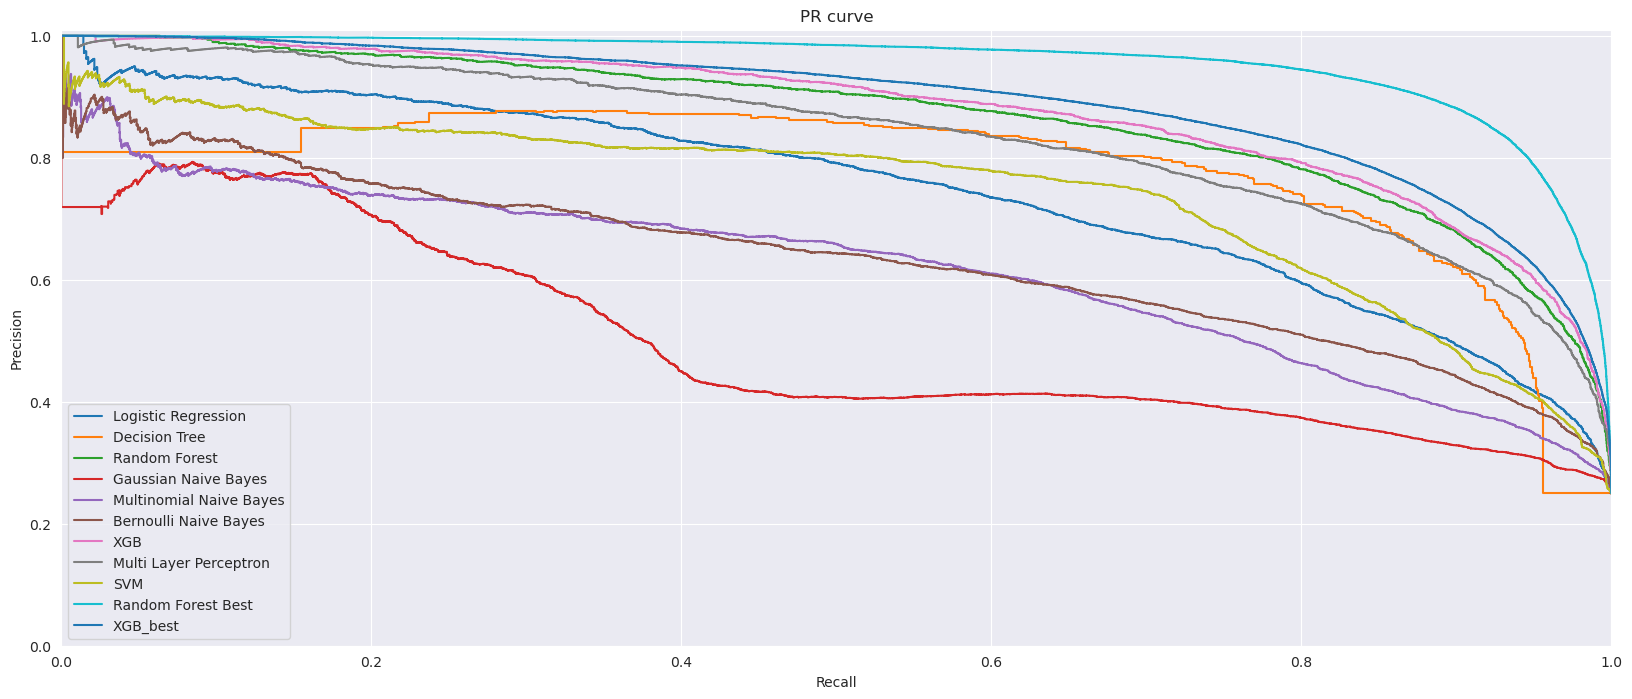

In [379]:
plt.figure(figsize=(20, 8))
for key in f1.keys():
    plt.step(recall[key], precision[key], where="post", label=key)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR curve")
plt.legend()
plt.savefig("All_Models_PR_Curve_plot.png",bbox_inches = 'tight', dpi = 300)
plt.show()

#### ROC Curve Comparision between Models

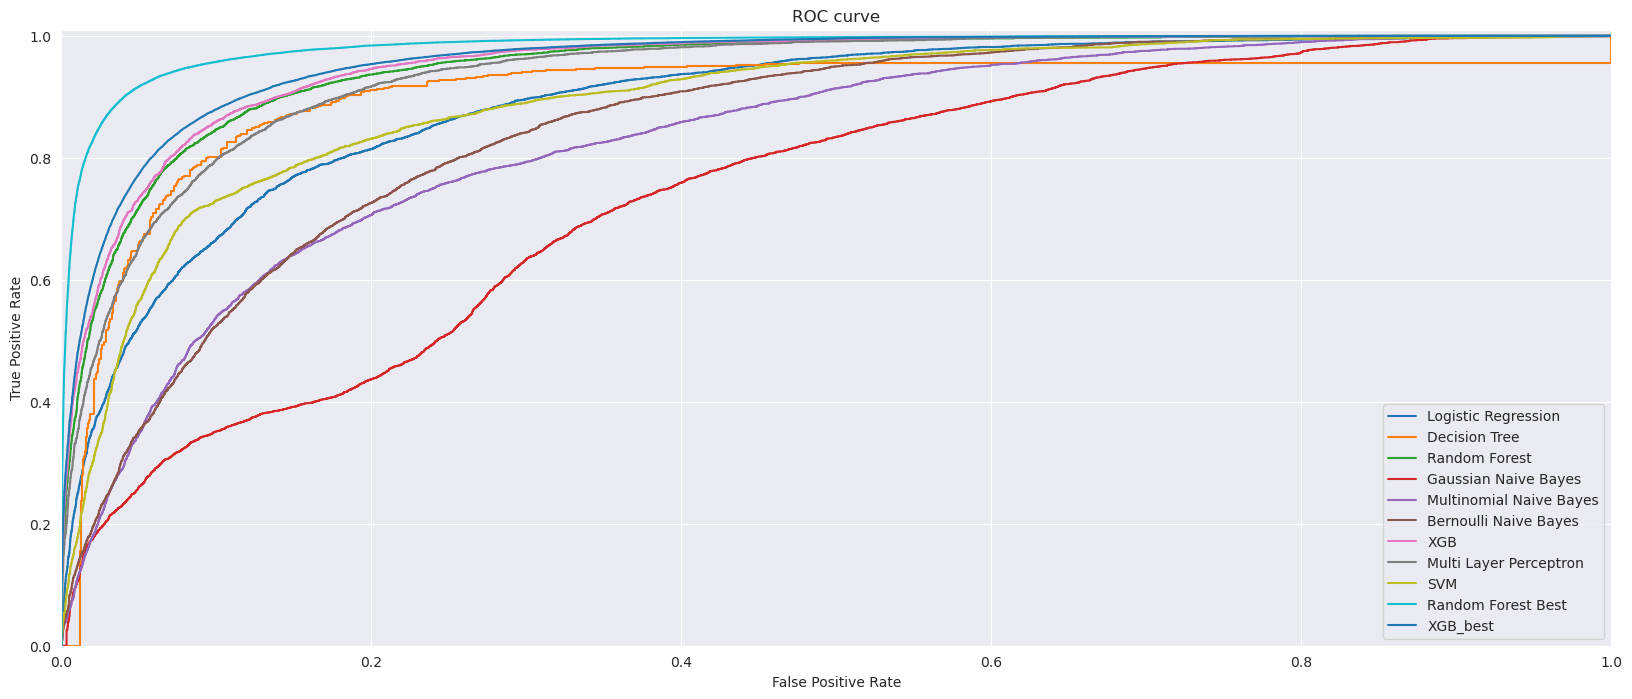

In [380]:
plt.figure(figsize=(20, 8))
for key in f1.keys():
    plt.step(fpr[key], tpr[key], where="post", label=key)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("ROC curve")
plt.legend()
plt.savefig("All_Models_ROC_Curve_plot.png",bbox_inches = 'tight', dpi = 300)
plt.show()

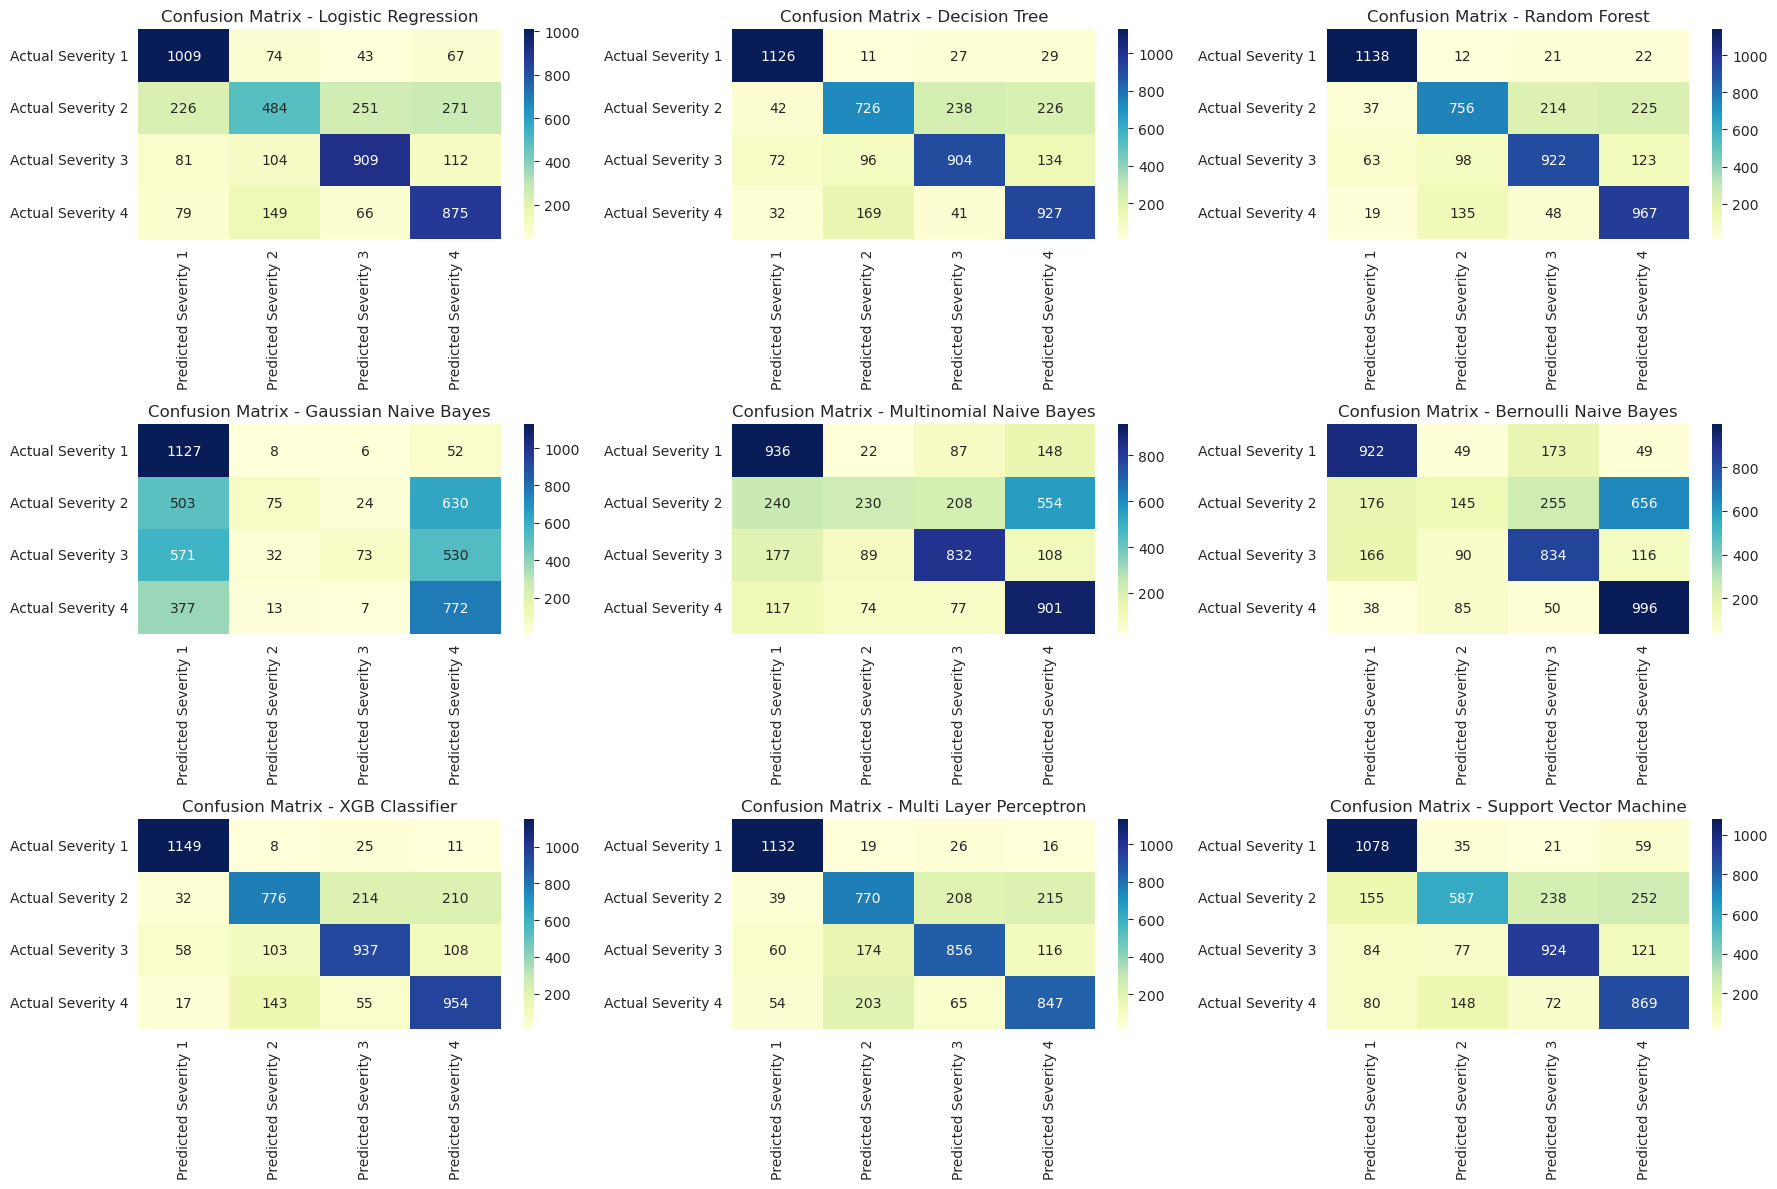

In [355]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.ravel()
for i, (name, model) in enumerate(models.items()):
    ax = axs[i]
    y_pred = model.predict(X_val_sample)
    if name == "XGB Classifier":
        confmat = confusion_matrix(y_true=y_val_encoded, y_pred=y_pred)
    else:
        confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

    index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
    columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
    conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")

# Hide the remaining subplots
for j in range(len(models), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.savefig("All_Models_Conf_Matrix_Plot.png",bbox_inches = 'tight', dpi = 300)
plt.show()

### Model Training Observations
- Every model trained at different speeds, I believe this majorly was due to different complexity of models
- By observing the performance metrics and curves on validation data, I think the best models are XGB classifier and Random Forest Classifier
- This can even be observed by the confusion matrices
- We will now train Random Forest Classifier and XGB Classifier with the best params on full dataset and save the pickle files

## Best Model Training On Whole Datasets

### Random Forest Classifier

In [356]:
print("Random Forest Classifier Scores After Training on Whole Dataset:")
best_rfc = RandomForestClassifier(**best_params['rfc'],random_state = 42)
best_rfc.fit(X_train, y_train)
print("Train Score: ", best_rfc.score(X_train, y_train))
print("Validation Score: ", best_rfc.score(X_val, y_val))

Random Forest Classifier Scores After Training on Whole Dataset:
Train Score:  0.9965762117919476
Validation Score:  0.8146111936602278


#### Random Forest Classifier Conf. Matrix on Validation Set

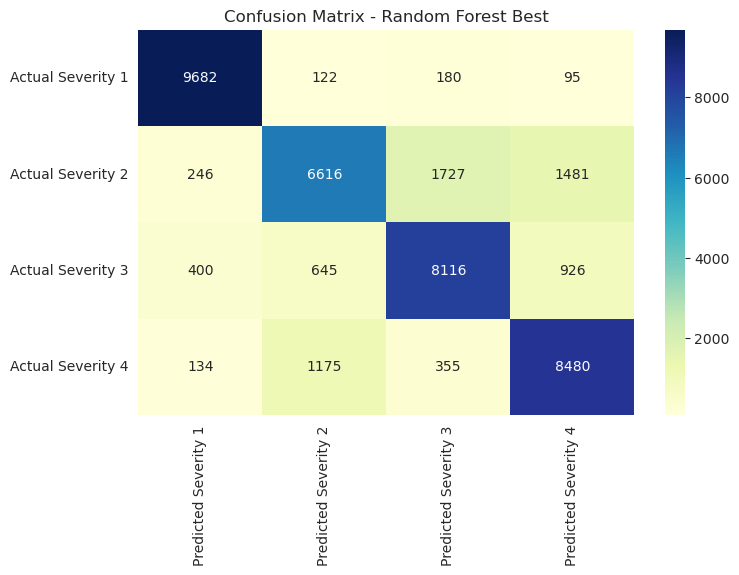

In [357]:
y_pred = best_rfc.predict(X_val)
confmat = confusion_matrix(y_true=y_val, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Random Forest Best")
plt.show()

#### Metrics Scores and Metric Visualizations for Random Forest Classifier with best params

In [358]:
y_pred = best_rfc.predict(X_val)

accuracy["Random Forest Best"] = accuracy_score(y_val, y_pred)
f1["Random Forest Best"] = f1_score(y_val, y_pred, average="macro")

print(classification_report(y_train, best_rfc.predict(X_train)))
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     40486
           2       1.00      0.99      1.00     40372
           3       0.99      1.00      1.00     40370
           4       1.00      1.00      1.00     40289

    accuracy                           1.00    161517
   macro avg       1.00      1.00      1.00    161517
weighted avg       1.00      1.00      1.00    161517

              precision    recall  f1-score   support

           1       0.93      0.96      0.94     10079
           2       0.77      0.66      0.71     10070
           3       0.78      0.80      0.79     10087
           4       0.77      0.84      0.80     10144

    accuracy                           0.81     40380
   macro avg       0.81      0.81      0.81     40380
weighted avg       0.81      0.81      0.81     40380



#### Random Forest Classifier Precision vs Recall Curve on Validation Set

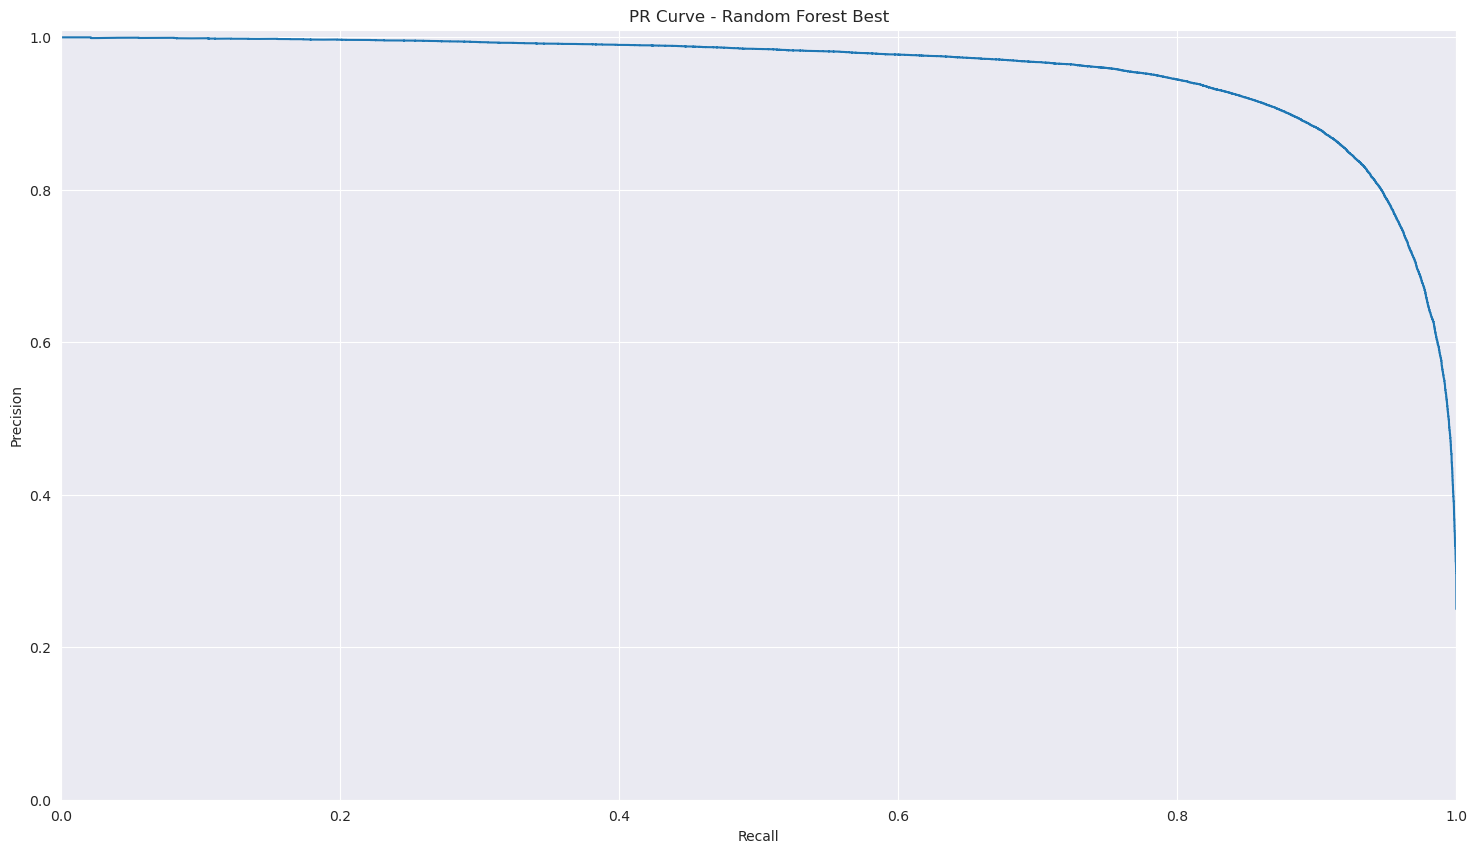

In [359]:
Y = label_binarize(y_val, classes=[1, 2, 3, 4])

y_score = rfc.predict_proba(X_val)

precision["Random Forest Best"], recall["Random Forest Best"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Random Forest Best"], tpr["Random Forest Best"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Random Forest Best"], precision["Random Forest Best"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Random Forest Best")
plt.show()

#### Random Forest Classifier ROC Curve on Validation Set

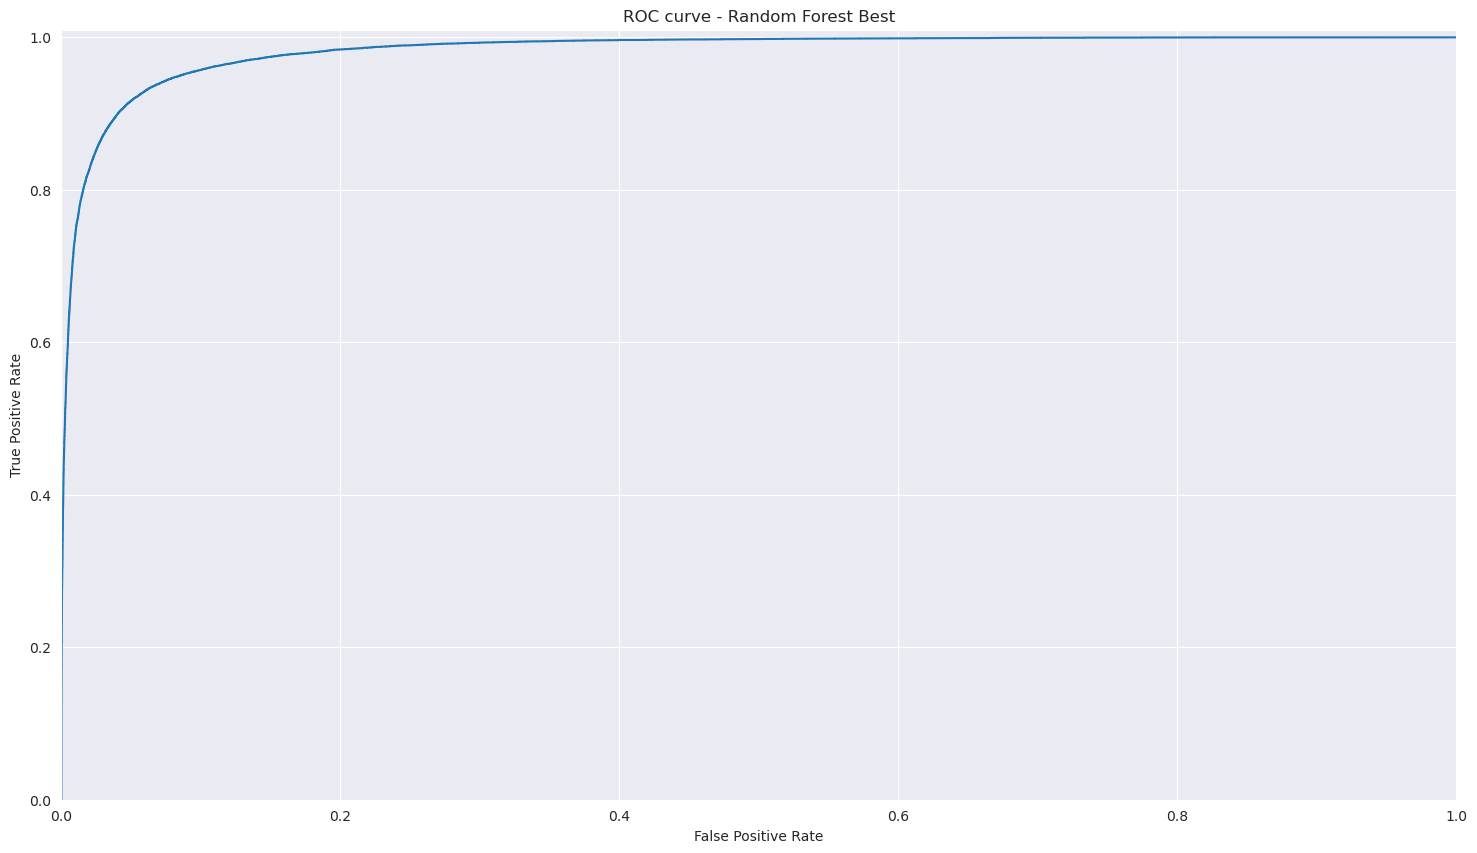

In [360]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Random Forest Best"], tpr["Random Forest Best"], where="post")

plt.title("ROC curve - Random Forest Best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

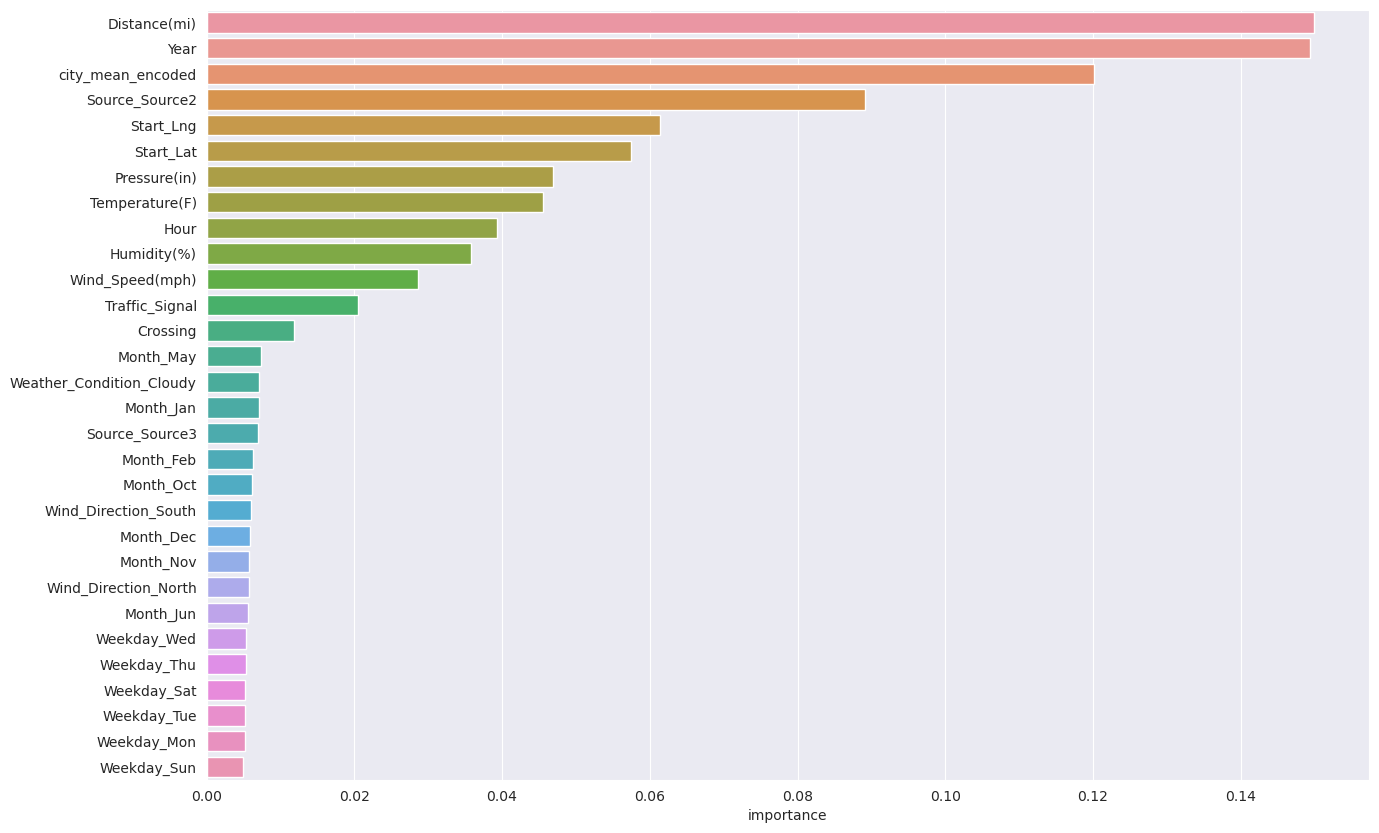

In [361]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = best_rfc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

### XGBoost Classifier
- This algo requires the target labels to start from 0 so we transform the target
| Original Label | Encoded Label |
| -------------- | ------------- |
|       1        |       0       |
|       2        |       1       |
|       3        |       2       |
|       4        |       3       |


In [362]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

#### Running the best params XGB Model

In [363]:
print("XGB Classifier Scores After Training on Whole Dataset:")
# 
best_xgb = XGBClassifier(**best_params['xgb'],random_state=42)
best_xgb.fit(X_train, y_train_encoded)
print("Train Score: ", best_xgb.score(X_train, y_train_encoded))
print("Validation Score: ", best_xgb.score(X_val, y_val_encoded))

XGB Classifier Scores After Training on Whole Dataset:
Train Score:  0.8237894463121529
Validation Score:  0.8105002476473502


#### XGB Conf. Matrix on Validation Set

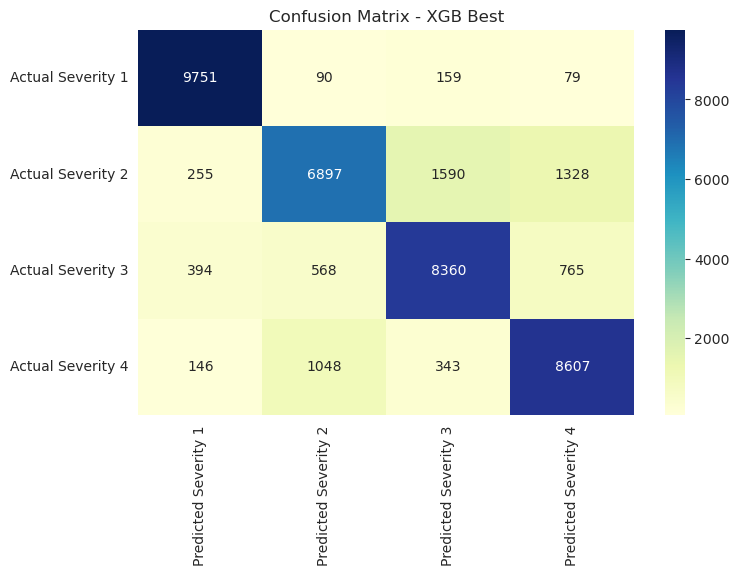

In [364]:
y_pred = xgb.predict(X_val)
confmat = confusion_matrix(y_true=y_val_encoded, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - XGB Best")
plt.show()

#### Metrics Scores and Metric Visualizations for XGB with best params

In [365]:
y_pred = xgb.predict(X_val)

accuracy["XGB_best"] = accuracy_score(y_val_encoded, y_pred)
f1["XGB_best"] = f1_score(y_val_encoded, y_pred, average="macro")

print(classification_report(y_train_encoded, best_xgb.predict(X_train)))
print(classification_report(y_val_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     40486
           1       0.79      0.68      0.73     40372
           2       0.79      0.82      0.81     40370
           3       0.78      0.83      0.81     40289

    accuracy                           0.82    161517
   macro avg       0.82      0.82      0.82    161517
weighted avg       0.82      0.82      0.82    161517

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10079
           1       0.80      0.68      0.74     10070
           2       0.80      0.83      0.81     10087
           3       0.80      0.85      0.82     10144

    accuracy                           0.83     40380
   macro avg       0.83      0.83      0.83     40380
weighted avg       0.83      0.83      0.83     40380



#### XGB Precision vs Recall Curve on Validation Set

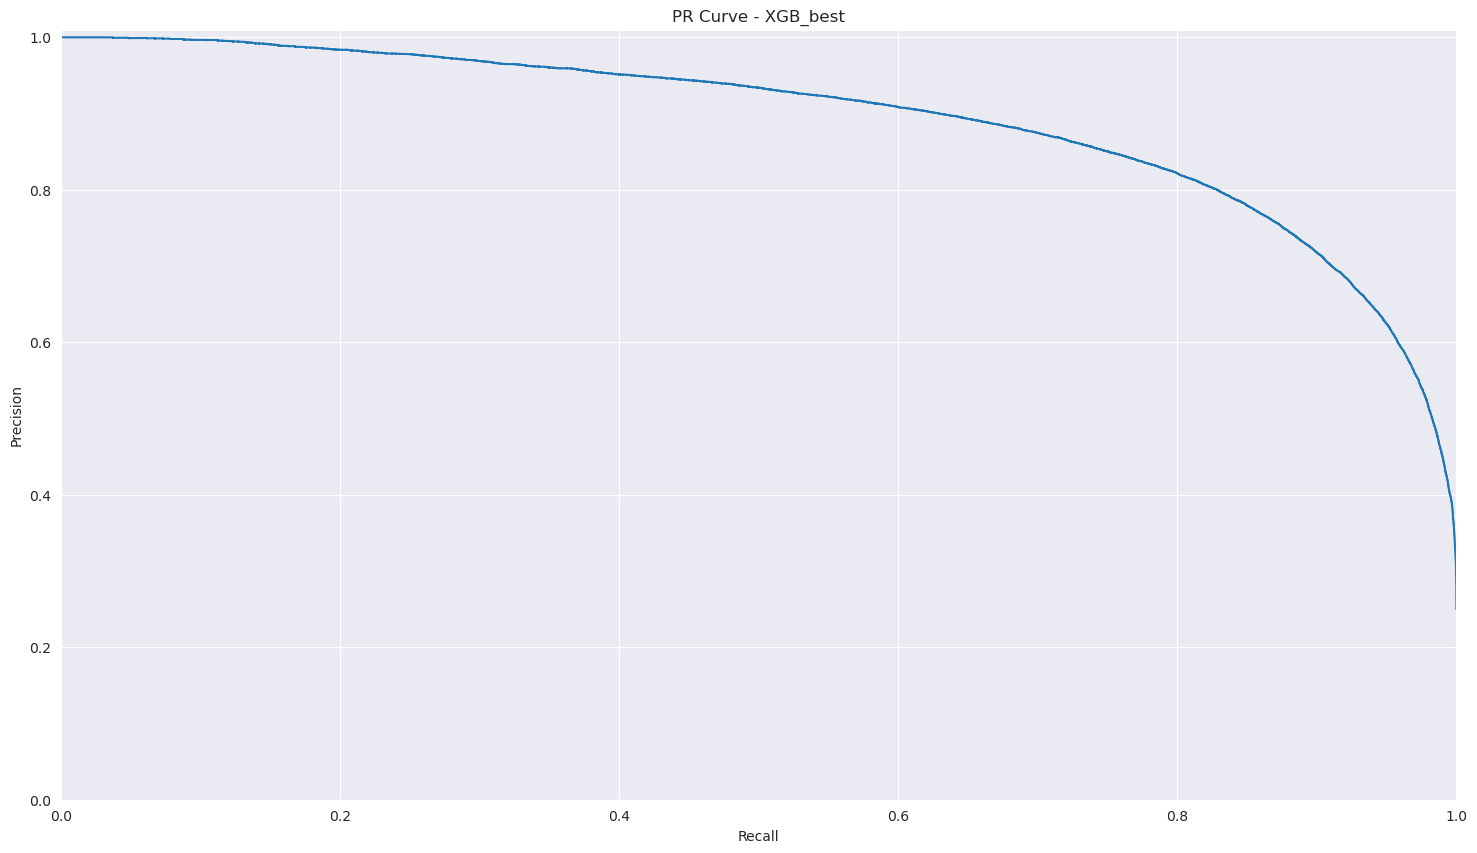

In [367]:
Y = label_binarize(y_val_encoded, classes=[0, 1, 2, 3])

y_score = best_xgb.predict_proba(X_val)

precision["XGB_best"], recall["XGB_best"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["XGB_best"], tpr["XGB_best"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["XGB_best"], precision["XGB_best"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - XGB_best")
plt.show()

#### XGB ROC Curve on Validation Set

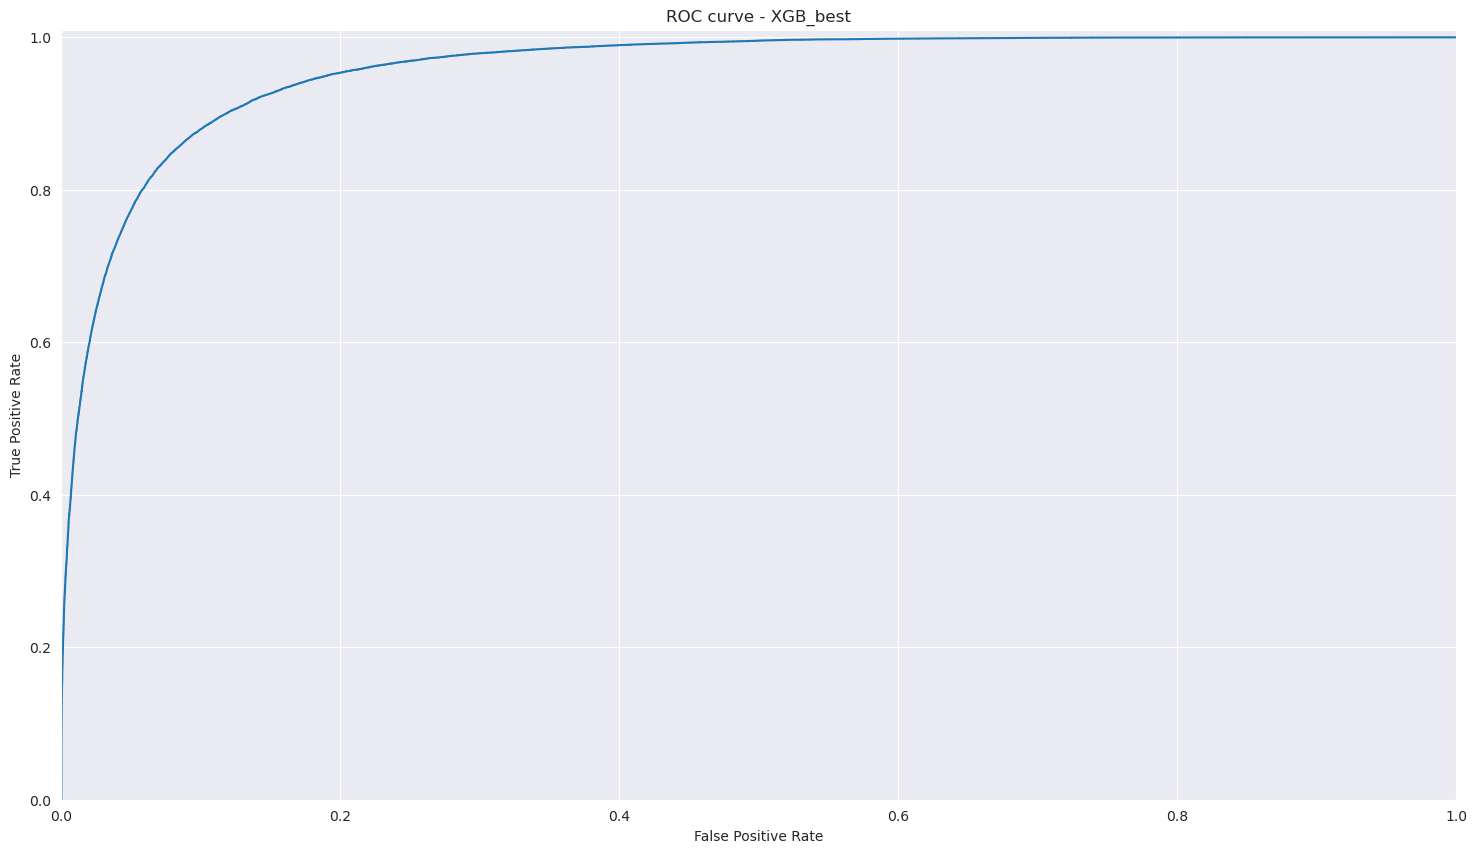

In [368]:
plt.figure(figsize=(18, 10))
plt.step(fpr["XGB_best"], tpr["XGB_best"], where="post")

plt.title("ROC curve - XGB_best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

### Comparing Results between XGB n Random Forest Regressor after training on whole dataset

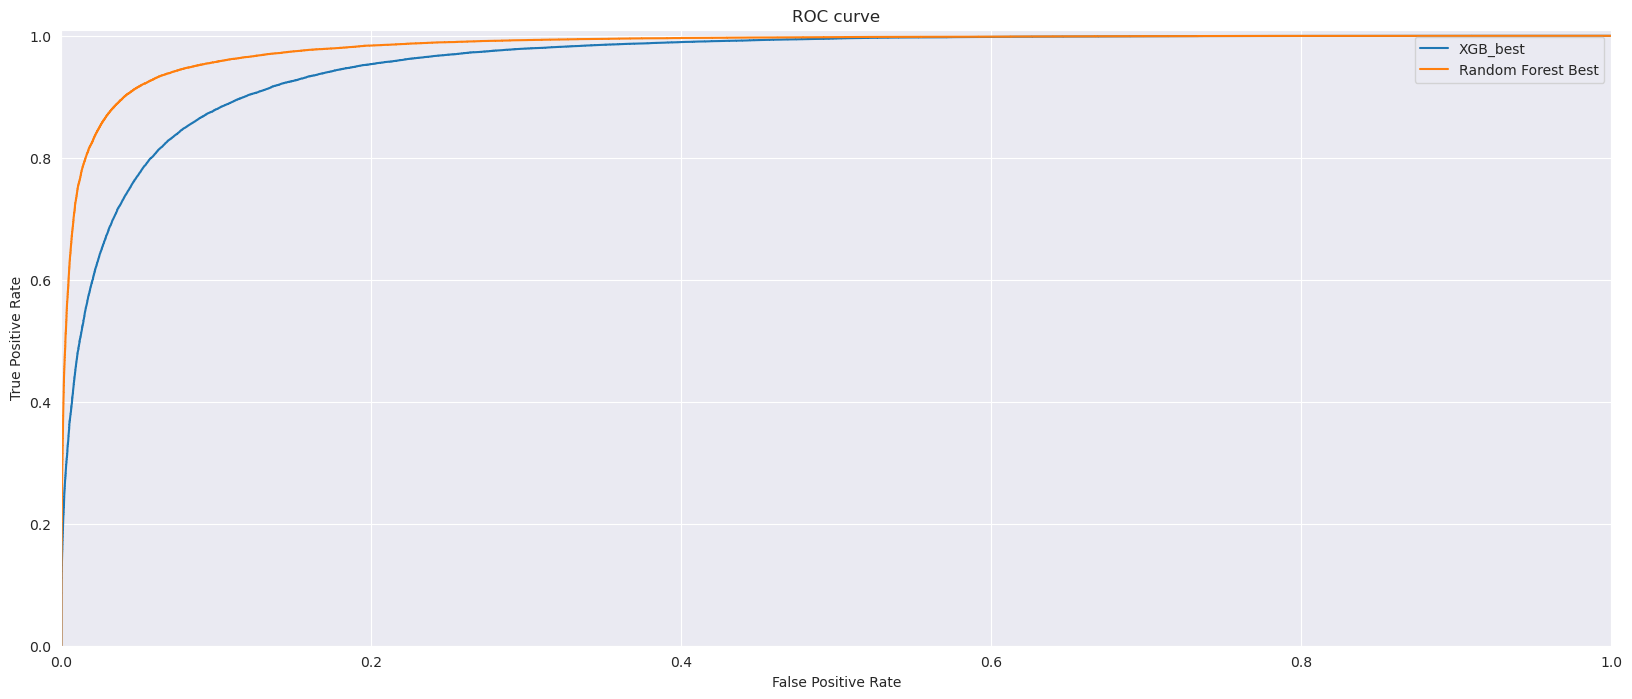

In [374]:
plt.figure(figsize=(20, 8))
keys = ["XGB_best","Random Forest Best"]
for key in keys:
    plt.step(fpr[key], tpr[key], where="post", label=key)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("ROC curve")
plt.legend()
plt.savefig("Best_Model_Comparision_ROC_Curve_plot.png",bbox_inches = 'tight', dpi = 300)
plt.show()

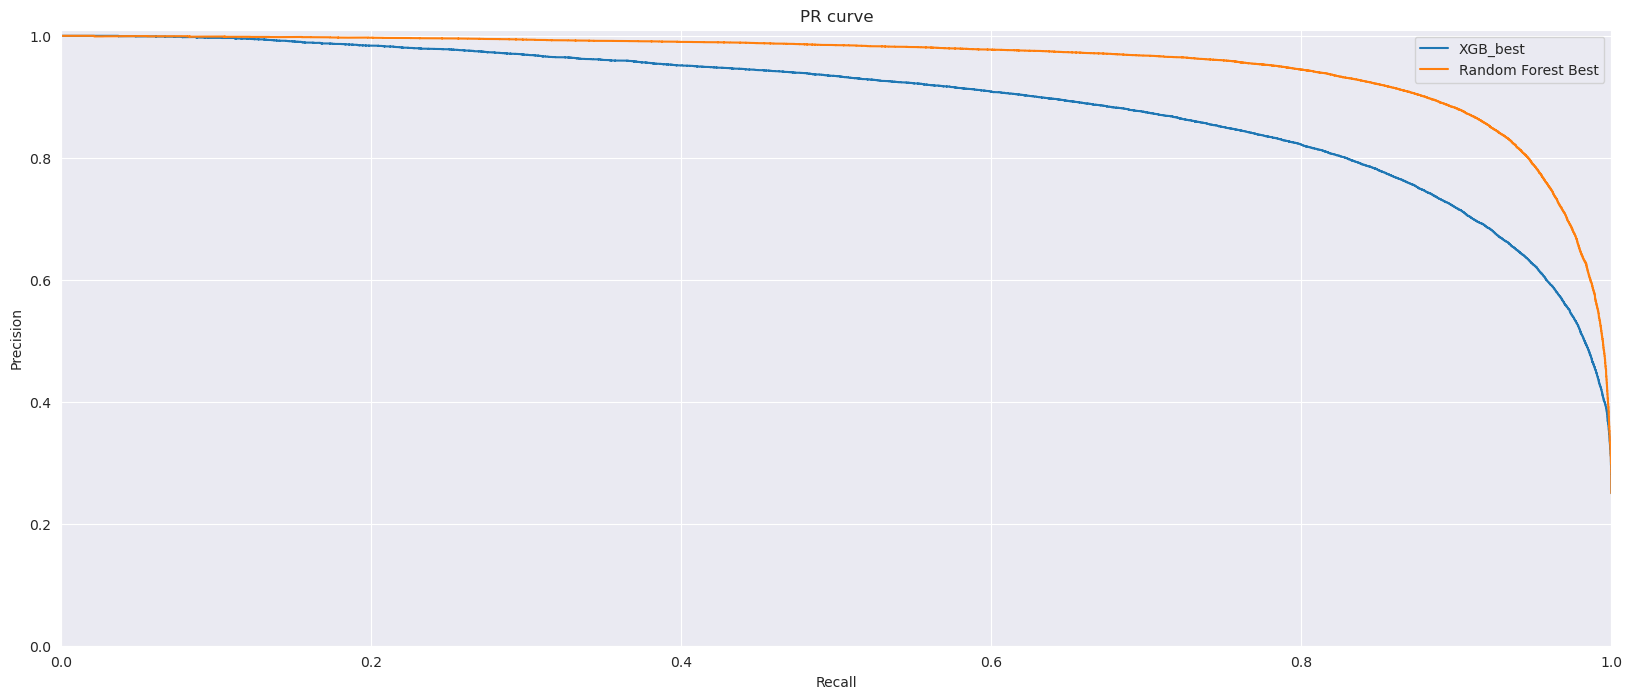

In [375]:
plt.figure(figsize=(20, 8))
keys = ["XGB_best","Random Forest Best"]
for key in keys:
    plt.step(recall[key], precision[key], where="post", label=key)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR curve")
plt.legend()
plt.savefig("Best_Model_Comparision_PR_Curve_plot.png",bbox_inches = 'tight', dpi = 300)
plt.show()

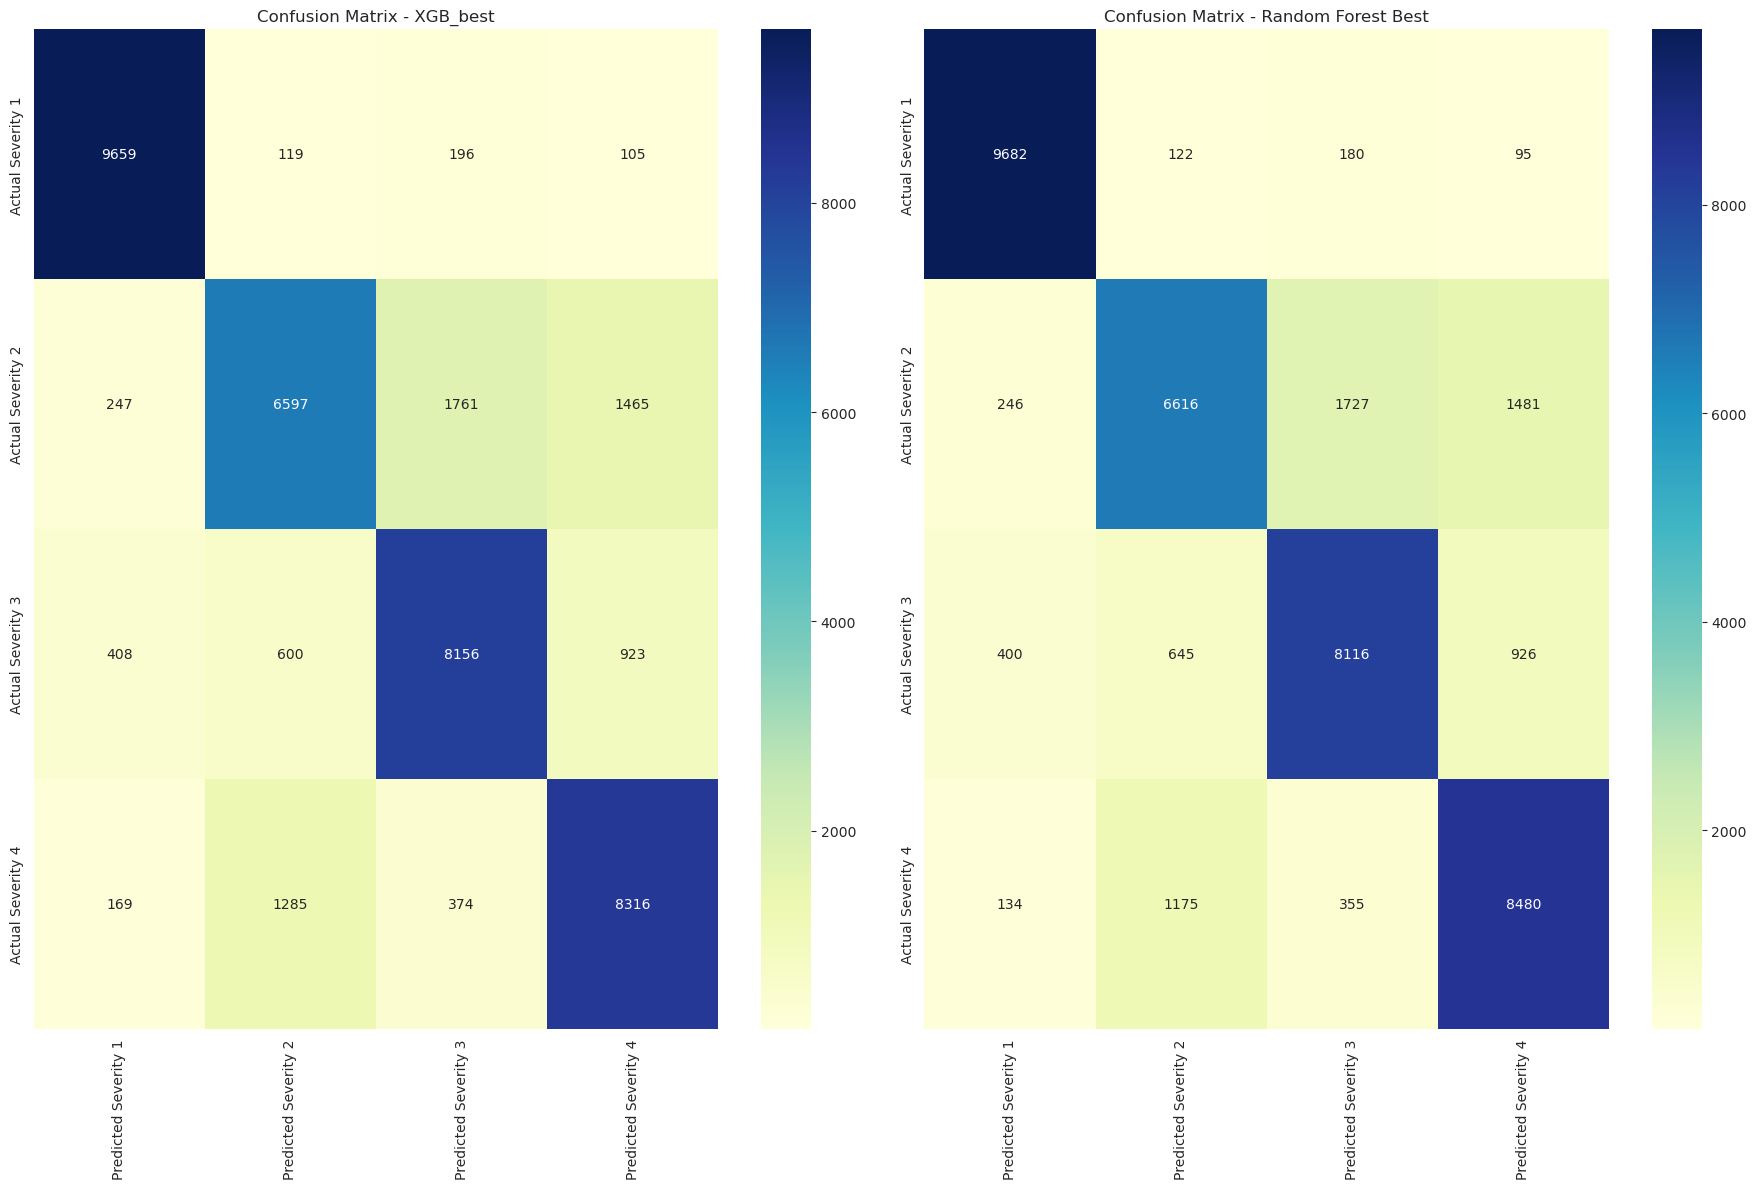

In [376]:
fig, axs = plt.subplots(1, 2, figsize=(18, 12))
best_models = {"XGB_best": best_xgb, "Random Forest Best": best_rfc}
axs = axs.ravel()
for i, (name, model) in enumerate(best_models.items()):
    ax = axs[i]
    y_pred = model.predict(X_val)
    if name == "XGB_best":
        confmat = confusion_matrix(y_true=y_val_encoded, y_pred=y_pred)
    else:
        confmat = confusion_matrix(y_true=y_val, y_pred=y_pred)

    index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
    columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
    conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")

# Hide the remaining subplots
for j in range(len(models), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.savefig("Best Models Conf_Matrix_Plot.png",bbox_inches = 'tight', dpi = 300)
plt.show()

## Conclusion of Model Training

- Random Forest classifier performs the best on US-Accidents Severity Level Predictions
- Overall every model performs well on Severity Levels 1,3,4 on Validation sets, however the accuracy and recall decreases on Severity Level 2
    - The reasons for this can mainly be while balancing the data the sample that we chose for 2 Severity is not a good representative 
    - This is where one can retrain the models by choosing various random samples, or try including more data of Level 2 Severity and then retrain the models 
- Further every model can be trained using cuml GPU implementations on whole dataset, and then do more dense comparisions between models to select the best one

- Thank you for reading the work 😊